## Dataset

[Inside Airbnb](http://insideairbnb.com/get-the-data.html) has provided data that is sourced from public available infomration from Airbnb webiste. The data we used for this project is compiled on 6th of September, 2023. The dataset comprised of three tables and a geojson file of London boroughs:
* `listings` - Deatailed listings data for London
* `calendar` - Deatailed bookings for the next calendar year of listings
* `reviews` - Detailed reviews data for listings in London.
* `neigbourhoods` - geojson file of boroughs of London.

# Questions to be Answered.

 * `1. Which Boroughs are more expensive and which area have the best reviews.`
 * `2. Which property type has highest listening and what room type has higher price `
 * `3. What are the essential ammenities needed `?
 * `4. What is the correlation of their remarks with the reviews `
 * `5. What Features affect price the most and what features affect the average price over time. `
 * `6. What is the Impact of external factors such as Economic Indicators to the Price `
 * `7. Which Features affect the book rate the most `
 * `8. Which month is the most expensive month to travel on ` 
 * `9. How is the demand for Airbnb changing in London and the number of reviews across the years. `
 * `10.Use time series analysis (e.g., SARIMA) to detect seasonal trends in prices and occupancy `


 ## In this project I dealt extensively with  different frameworks which are

 * Machine Learning Frameworks for feature importance, Sentimental Analysis and feature selection
 * Pyspark for Big Data Processing
 * Correlation and Seasonal Decomposition Analysis
 * Data Preprocessing and Cleaning
 * Economic Indicator analysis  and correlation

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
from pprint import pprint
import datetime
from src.utils import *



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# from catboost import CatBoostRegressor

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

%matplotlib inline

In [2]:
df_listings = load_csv('/Users/user/Downloads/listings (1).csv.gz')

In [3]:
print(f'There are {df_listings.shape[0]} number of listings in London as of {df_listings.last_scraped.max()}')

There are 87946 number of listings in London as of 2023-09-07


# Data Cleaning and Preparation

In [4]:
df_listings.isna().mean().sort_values(ascending=False)[:20]

neighbourhood_group_cleansed    1.000000
bathrooms                       1.000000
calendar_updated                1.000000
license                         0.999989
host_about                      0.478021
neighborhood_overview           0.463421
neighbourhood                   0.463409
host_neighbourhood              0.453312
bedrooms                        0.372660
host_response_time              0.328815
host_response_rate              0.328815
host_acceptance_rate            0.286403
review_scores_value             0.262957
review_scores_checkin           0.262945
review_scores_location          0.262945
review_scores_communication     0.262604
review_scores_accuracy          0.262582
review_scores_cleanliness       0.262445
last_review                     0.251950
first_review                    0.251950
dtype: float64

In [5]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87946 entries, 0 to 87945
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            87946 non-null  int64  
 1   listing_url                                   87946 non-null  object 
 2   scrape_id                                     87946 non-null  int64  
 3   last_scraped                                  87946 non-null  object 
 4   source                                        87946 non-null  object 
 5   name                                          87946 non-null  object 
 6   description                                   86679 non-null  object 
 7   neighborhood_overview                         47190 non-null  object 
 8   picture_url                                   87943 non-null  object 
 9   host_id                                       87946 non-null 

In [6]:
df_listings = df_listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights',
                                'minimum_maximum_nights', 'maximum_maximum_nights',
                                'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
                                'host_total_listings_count', 'calculated_host_listings_count',
                                'calculated_host_listings_count_entire_homes', 'beds',
                                'calculated_host_listings_count_private_rooms',
                                'calculated_host_listings_count_shared_rooms'], axis=1)


In [7]:
df_listings['has_availability'].value_counts()

t    83477
f     4469
Name: has_availability, dtype: int64

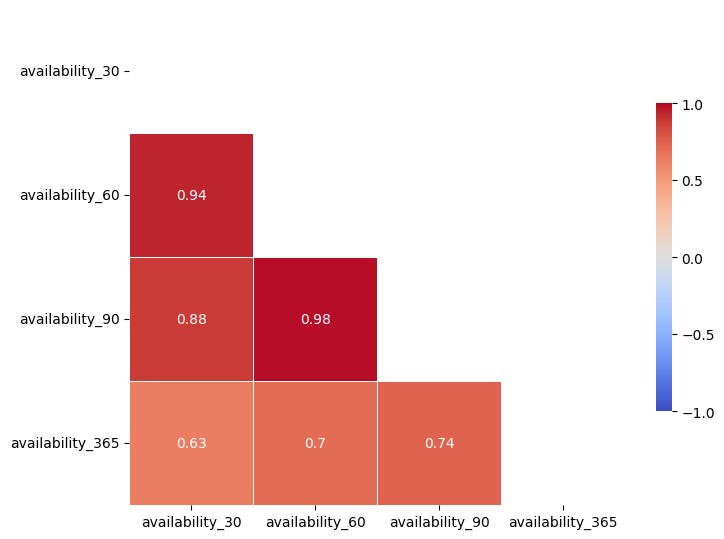

In [8]:
availability_col = ['availability_30', 'availability_60', 'availability_90', 'availability_365' ]
annotated_heatmap(df_listings, availability_col, figsize=(8, 8))

In [9]:
df_listings.host_response_time.fillna("unknown", inplace=True)
df_listings.host_response_time.value_counts(normalize=True)

within an hour        0.444466
unknown               0.328815
within a few hours    0.129273
within a day          0.074944
a few days or more    0.022502
Name: host_response_time, dtype: float64

In [10]:
print(f"The proportion of nan values in host_response rate column is around "
      f"{round(df_listings.host_response_rate.isna().sum() / len(df_listings) * 100, 1)}%")

The proportion of nan values in host_response rate column is around 32.9%


In [103]:
def bin_column(df, col, bins, labels, na_label='unknown'):
    """
    Takes a column, and segment continuous data into discrete bins with group of 
    labels and fill the na value of the column according to na_label
    
    Argument
    ========
    df: pandas dataframe
    col: str, column of dataframe
    bins: int, the criteria to bin by
    labels: arrays, specify labels for the returned bins
    na_label: values to replace missing values in col
    
    Returns
    """
    
    if df[col].dtype == 'O':
        df[col] = df[col].str[:-1].astype('float64')
        
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].replace('nan', 'unknown', inplace=True)
    df[col].fillna(na_label, inplace=True)
    

def clean_listings(df1):
    """
    Remove the dollar size in the price col, fill nan value with 0 for price col
    and median for room_col, and drop rows for host_col

    Argument
    ========
    df: pandas dataframe

    Returns
    Cleaned dataframe

    """

    price_col = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
    room_col = ['bathrooms', 'bedrooms']
    host_col = ['host_is_superhost', 'host_identity_verified',
                'host_has_profile_pic', 'host_listings_count']

    

    df1  = df1.replace(to_replace='unknow',value=np.nan)

    print(df1.head())
    df1  = df1.replace(to_replace='unknown',value=np.nan)
    df1  = df1.replace(to_replace='',value=np.nan)
    df1 = df1.fillna(df1.mode().iloc[0])

    df1[price_col] = df1[price_col].apply(lambda x: x.str[1:], axis=0)
    df1[price_col] = df1[price_col].apply(
        lambda x: x.str.replace(",", '')).astype('float64')
    df1[price_col] = df1[price_col].fillna(value=0)

    df1[room_col] = df1[room_col].fillna(df1[room_col].median())
    df1.dropna(subset=host_col, inplace=True)

    return df1

In [12]:
df_listings[['host_is_superhost', 'host_identity_verified',
    'host_has_profile_pic', 'host_listings_count']].isna().sum()

host_is_superhost         932
host_identity_verified      5
host_has_profile_pic        5
host_listings_count         5
dtype: int64

In [384]:
bin_column(df_listings, 'host_response_rate',
          bins=[0, 50, 75, 90, 100], 
          labels=['0-49%', '50-74%',
                  '75-89%', '90-100%'],
          )




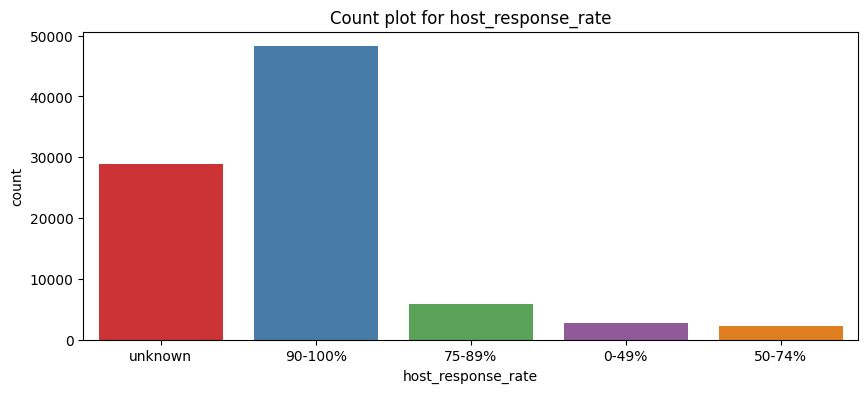

In [14]:
plot_categorical(df_listings, 'host_response_rate', 'host_response.png', hue=None, palette='Set1', figsize=(10,4))

* ## It appears that there was a good performance of host response rate, However  before we make assertions we need to check further because we have a number of  unknown responses

In [15]:
df_listings['price'] = df_listings['price'].str.replace('$', '').str.replace(',', '').astype(float)
borough_geo = '/Users/user/Downloads/neighbourhoods.geojson'
borough_df = pd.DataFrame(df_listings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean())
borough_df.rename(columns={0: 'review_scores_rating'}, inplace=True)
borough_df['median_price'] = df_listings.groupby('neighbourhood_cleansed').price.median()
borough_df = borough_df.reset_index()

/Users/user/Airbnb data analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


## `1. Which Boroughs are more expensive and which area have the best reviews?`

In [16]:
borough_df.sort_values(by='median_price', ascending=False)

neighbourhood_cleansed  review_scores_rating  median_price
32             Westminster              4.541033         199.0
19  Kensington and Chelsea              4.565890         195.0
6           City of London              4.510752         170.0
5                   Camden              4.539880         135.0
12  Hammersmith and Fulham              4.606061         125.0
26    Richmond upon Thames              4.706461         117.0
31              Wandsworth              4.662160         111.0
18               Islington              4.594712         109.0
27               Southwark              4.627600         100.0
23                  Merton              4.669181         100.0
17                Hounslow              4.525468          99.0
21                 Lambeth              4.654759          98.0
11                 Hackney              4.674173          98.0
29           Tower Hamlets              4.527131          95.0
1                   Barnet              4.602639          93.0
10               Greenwich              4.594299          90.0
3                    Brent              4.580713          90.0
24                  Newham              4.526056          86.0
8                   Ealing              4.607964          85.0
20    Kingston upon Thames              4.737269          85.0
22                Lewisham              4.622688          80.0
15                Havering              4.668877          80.0
13                Haringey              4.641584          80.0
30          Waltham Forest              4.678620          77.0
14                  Harrow              4.500456          76.0
0     Barking and Dagenham              4.551263          75.0
9                  Enfield              4.605825          75.0
4                  Bromley              4.685929          75.0
16              Hillingdon              4.499471          71.0
25               Redbridge              4.571758          70.0
28                  Sutton              4.665502          70.0
7                  Croydon              4.571561          70.0
2                   Bexley              4.609408          65.0

In [17]:
borough_df.sort_values(by='review_scores_rating', ascending=False).head(5)

neighbourhood_cleansed  review_scores_rating  median_price
20   Kingston upon Thames              4.737269          85.0
26   Richmond upon Thames              4.706461         117.0
4                 Bromley              4.685929          75.0
30         Waltham Forest              4.678620          77.0
11                Hackney              4.674173          98.0

In [385]:
def plot_dist(df,hue, x = 'bedrooms', y = 'price', split = False, fig = None, nrows = 1, ncols = 1, figsize = (10, 5)):
    '''
    Usage: plot the distribution
    Input:
    df - input dataframe
    x - plotted variable name on x-axis
    y - plotted variable name on y-axis
    split - True: show Boston and Seattle data in separate plots
            False: show Boston and Seattle data in one plot
    plot_dist - True: a one plot to show the distribution of x-components, only applied when split is False
    figsize - size of the figure  
    Output: axis of the plot
    '''

    # plot_data = df.groupby(by = ['city', x]).mean()[[y]].reset_index()
    # plot_data = plot_data.sort_values(by = y, ascending = True)
 

    if split:
        plot_data = df.copy()
        plot_data = plot_data.groupby(by = [x]).mean()[[y]].reset_index()
        plot_data = plot_data.sort_values(by = y, ascending = True)
        ax = plot_data.plot.bar(x=x, y=y, figsize = figsize, title = '')
        ax.set_ylim(50, 350)
    else:
        if fig is None:
            fig = plt.figure(figsize = figsize)
            ax = fig.add_subplot()            
        else:
            plot_data = df.copy()
            plot_data = plot_data.groupby(by = [hue, x]).mean()[[y]].reset_index()
            plot_data = plot_data.sort_values(by = y, ascending = True)
            ax = plot_data.plot.bar(x=x, y=y, figsize = figsize, title = '')
            ax.set_ylim(50, 350)
            ax = fig.add_subplot(nrows, ncols, 1)
        ax = sns.barplot(data = plot_data, x = x, y = y,hue=hue,ax = ax)
        ax.set_title('Averaged Price based on '+ x)

    print('Boston Price Ranged From {} to {}, average: {}' \
          .format(int(plot_data.price.min()), int(plot_data.price.max()), int(plot_data.price.mean())))
    return ax

def count_plot(data, feature, hue, ax = None, normalized = False):
    '''
    Usage: plot the distribution
    Input:
    data - input dataframe
    feature, hue - names of variables in data
    ax - size of the figure  
    normalized - True: show in percentage
               - False: show in count
    Output: axis of the plot
    '''
    if ax is None:
        fig = plt.figure(figsize = (20, 20))
    else:
        fig = ax.get_figure()
    
    ax = fig.add_subplot()
    if normalized is False:
        ax = sns.countplot(x = feature, hue = hue, data = data, ax = ax)
    else:
        data_ = (data.groupby([hue])[feature].value_counts(normalize=True).rename('percentage').mul(100)\
                 .reset_index().sort_values(feature))
        ax = sns.barplot(x=feature, y="percentage", hue=hue, data=data_, ax = ax)
        ax.set_title('Percent Count Distribution')
    return ax


Boston Price Ranged From 89 to 320, average: 154


<AxesSubplot:xlabel='neighbourhood_cleansed'>

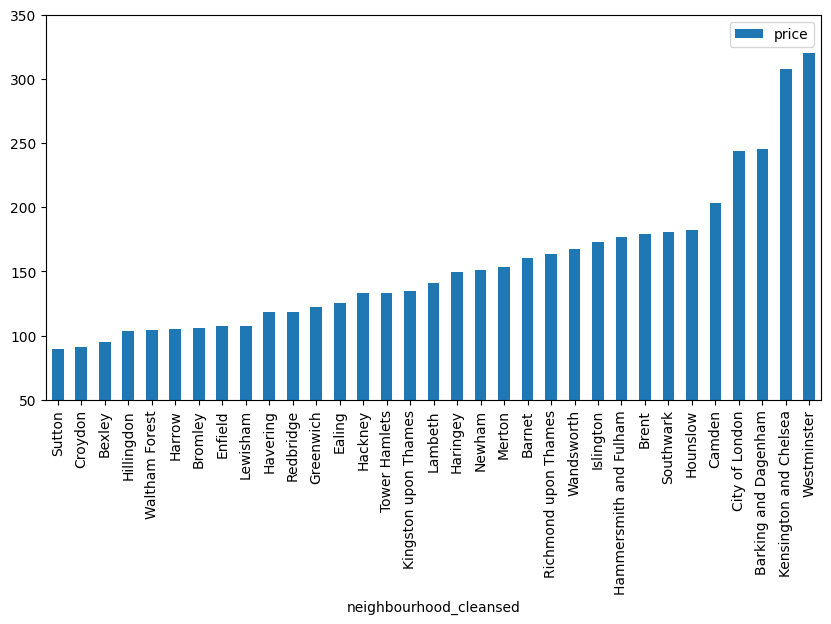

In [386]:
plot_dist(df=df_listings.copy(),hue=None, x = 'neighbourhood_cleansed', y = 'price', split = True, fig = None, nrows = 1, ncols = 1, figsize = (10, 5))

In [387]:
price_col = ['neighbourhood_cleansed', 'median_price']
price_london_map = london_map(borough_geo, borough_df, price_col, key_on='feature.properties.neighbourhood', 
                              legend='Median Price')
price_london_map

In [388]:
review_col = ['neighbourhood_cleansed', 'review_scores_rating']
review_london_map = london_map(borough_geo, borough_df, review_col, key_on='feature.properties.neighbourhood', 
                              legend='Average review scores', marker=False)
review_london_map

In [389]:
borough_df.sort_values('review_scores_rating', ascending=False)

neighbourhood_cleansed  review_scores_rating  median_price
20    Kingston upon Thames              4.737269          85.0
26    Richmond upon Thames              4.706461         117.0
4                  Bromley              4.685929          75.0
30          Waltham Forest              4.678620          77.0
11                 Hackney              4.674173          98.0
23                  Merton              4.669181         100.0
15                Havering              4.668877          80.0
28                  Sutton              4.665502          70.0
31              Wandsworth              4.662160         111.0
21                 Lambeth              4.654759          98.0
13                Haringey              4.641584          80.0
27               Southwark              4.627600         100.0
22                Lewisham              4.622688          80.0
2                   Bexley              4.609408          65.0
8                   Ealing              4.607964          85.0
12  Hammersmith and Fulham              4.606061         125.0
9                  Enfield              4.605825          75.0
1                   Barnet              4.602639          93.0
18               Islington              4.594712         109.0
10               Greenwich              4.594299          90.0
3                    Brent              4.580713          90.0
25               Redbridge              4.571758          70.0
7                  Croydon              4.571561          70.0
19  Kensington and Chelsea              4.565890         195.0
0     Barking and Dagenham              4.551263          75.0
32             Westminster              4.541033         199.0
5                   Camden              4.539880         135.0
29           Tower Hamlets              4.527131          95.0
24                  Newham              4.526056          86.0
17                Hounslow              4.525468          99.0
6           City of London              4.510752         170.0
14                  Harrow              4.500456          76.0
16              Hillingdon              4.499471          71.0

 **Whcih boroughs are more expensive, and which areas have the best reviews?**

* The City of Westminster borough is the most expensive borough to book a property. This borough closes to many of the famous London landmarks, shopping areas and night-time entertainment area Soho. The second Kensington and Chelsea borough. This borough is closed to many of the museums and department stores such as Harrods, Peter Jones and Harvey Nichols. In general, inner london has much higher than than outer london area.

* All of the london boroughs has average score ratings higher than 90 out of 100. As opposed to the price, outer london has higher review score ratings than inner london. kingston upon Thames is the highest scores rating borough. The borough is home to open space such as Richmond Park, Kew Gardens, Bushy Park and Old Deer Park. 

 ## * `2. Which property type has highest listening and what room type has higher price `

In [18]:
def categorize_property_types(property_list):
    # Define the keywords for each property type category
    categories = {
        'House': {'house', 'cottage', 'bungalow'},
        'Apartment': {'apartment', 'loft', 'condo'},
        'Guesthouse': {'guesthouse', 'villa', 'chalet'},
        'Hotel': {'hotel', 'resort', 'inn', 'lodge'}
    }

    categorized_list = []
    
    # Function to determine the category of a property type
    def get_category(prop_type):
        prop_type_lower = prop_type.lower()
        for category, keywords in categories.items():
            if any(keyword in prop_type_lower for keyword in keywords):
                return category
        return 'Other'

    # Categorize the property types
    for prop_type in property_list:
        categorized_list.append(get_category(prop_type))

    return categorized_list



# Sample property list
property_types  = list(df_listings.property_type)

# Categorize the property types
df_listings['Category'] = categorize_property_types(df_listings["property_type"])




In [19]:
df_listings.Category.value_counts()

Other         68547
Apartment     14985
House          3315
Hotel          1040
Guesthouse       59
Name: Category, dtype: int64

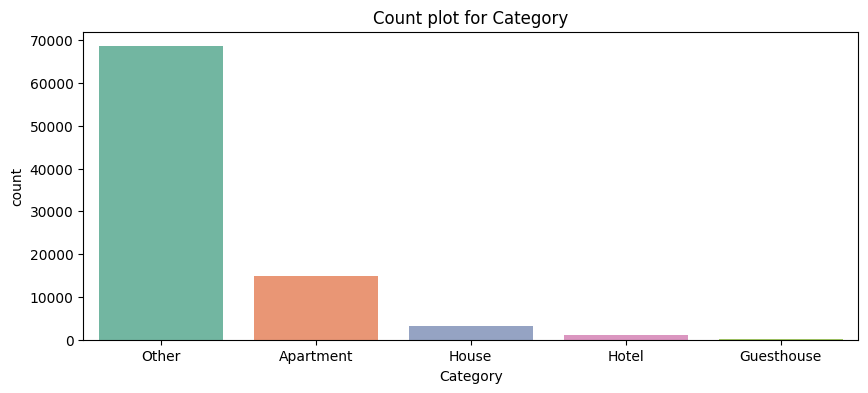

In [20]:
plot_categorical(df_listings, 'Category', 'Category.png', hue=None, palette='Set2', figsize=(10,4))

In [21]:
df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)]

id                                      listing_url  \
0                   92644               https://www.airbnb.com/rooms/92644   
1                   93015               https://www.airbnb.com/rooms/93015   
2                   13913               https://www.airbnb.com/rooms/13913   
3                   15400               https://www.airbnb.com/rooms/15400   
4                   93734               https://www.airbnb.com/rooms/93734   
...                   ...                                              ...   
87940  973779750539727225  https://www.airbnb.com/rooms/973779750539727225   
87941  973781286754517228  https://www.airbnb.com/rooms/973781286754517228   
87942  973801695874775338  https://www.airbnb.com/rooms/973801695874775338   
87943  973811685656289740  https://www.airbnb.com/rooms/973811685656289740   
87945  973895808066047620  https://www.airbnb.com/rooms/973895808066047620   

            scrape_id last_scraped       source  \
0      20230906022807   2023-09-06  city scrape   
1      20230906022807   2023-09-06  city scrape   
2      20230906022807   2023-09-06  city scrape   
3      20230906022807   2023-09-06  city scrape   
4      20230906022807   2023-09-07  city scrape   
...               ...          ...          ...   
87940  20230906022807   2023-09-07  city scrape   
87941  20230906022807   2023-09-06  city scrape   
87942  20230906022807   2023-09-07  city scrape   
87943  20230906022807   2023-09-06  city scrape   
87945  20230906022807   2023-09-06  city scrape   

                                                    name  \
0      Rental unit in Earlsfield · ★4.57 · 1 bedroom ...   
1      Rental unit in Hammersmith · ★4.82 · 2 bedroom...   
2      Rental unit in Islington · ★4.80 · 1 bedroom ·...   
3      Rental unit in London · ★4.80 · 1 bedroom · 1 ...   
4      Condo in London · ★4.62 · 1 bedroom · 1 bed · ...   
...                                                  ...   
87940  Home in Greater London · ★New · 2 bedrooms · 4...   
87941  Rental unit in Greater London · ★New · 1 bedro...   
87942  Rental unit in Greater London · ★New · 1 bedro...   
87943  Home in Greater London · ★New · 1 bedroom · 5 ...   
87945  Rental unit in Greater London · ★New · 2 bedro...   

                                             description  \
0      <b>The space</b><br />Hi everyone! I have 2 ro...   
1      Gorgeous 2 bed ground floor apartment with per...   
2      My bright double bedroom with a large window h...   
3      Lots of windows and light.  St Luke's Gardens ...   
4      <b>During your stay</b><br />I’m a professiona...   
...                                                  ...   
87940  Forget your worries in this spacious and seren...   
87941  Enjoy a Experience unique look in the center o...   
87942  La Casita is a unique one bedroom flat in Sout...   
87943                                                NaN   
87945  Enjoy staying in the heart of London’s Holborn...   

                                   neighborhood_overview  \
0                                                    NaN   
1      A bit of history about the W14 area: <br />Com...   
2      Finsbury Park is a friendly melting pot commun...   
3                                         It is Chelsea.   
4                                                    NaN   
...                                                  ...   
87940                                                NaN   
87941                                                NaN   
87942                                                NaN   
87943                                                NaN   
87945  About the Holborn London Location:<br />The Ho...   

                                             picture_url    host_id  \
0      https://a0.muscache.com/pictures/715127/85bdb4...     498201   
1      https://a0.muscache.com/pictures/865937ec-ee56...     499704   
2      https://a0.muscache.com/pictures/miso/Hosting-...      54730   
3      https://a0.muscache

In [22]:
def box_plot_price(x, figsize=(10, 5)):
    """
    Return ordered box plots with differet categories x against price y 
    
    Arguments
    =========
        x: categorical variable
        figsize: tuple, size of the figure
    
    """
    filtered_df = df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)]
    sort_price = filtered_df.groupby(x)['price'].median()\
                 .sort_values(ascending=False).index
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(y='price', x=x, data=filtered_df, order=sort_price)
    ax.set_xticklabels(ax.get_xticklabels())
    

In [23]:
filtered_df = df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)]
filtered_df.groupby('Category')['price'].median()

Category
Apartment     138.0
Guesthouse    163.0
Hotel         172.5
House          90.5
Other         100.0
Name: price, dtype: float64

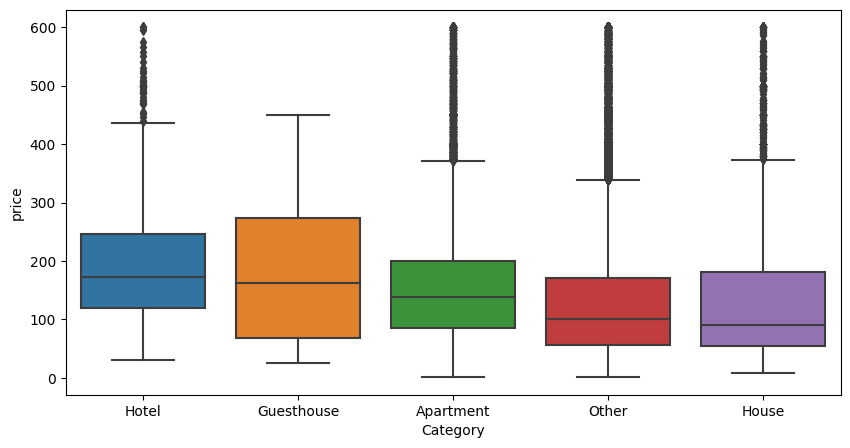

In [24]:
box_plot_price('Category')


- There are large number of property type that only has a few listings. We grouped similar property types into five categroies: House, Apartment, Guesthouse, Hotel, Other

- As expected, Hotel has the highest median price. Both Apartments and houses price varies a lot.

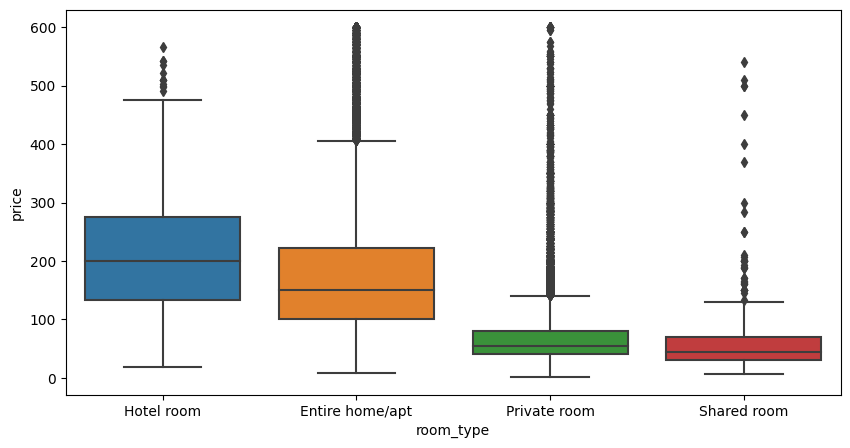

In [25]:
box_plot_price('room_type')

- Entire hotel rooms has much higher median price than the other room types

- As expected, many of the private room has price lower than £90. Also, Entire home/apt has high number of listings.

Text(0.5, 0, 'Listing price in $')

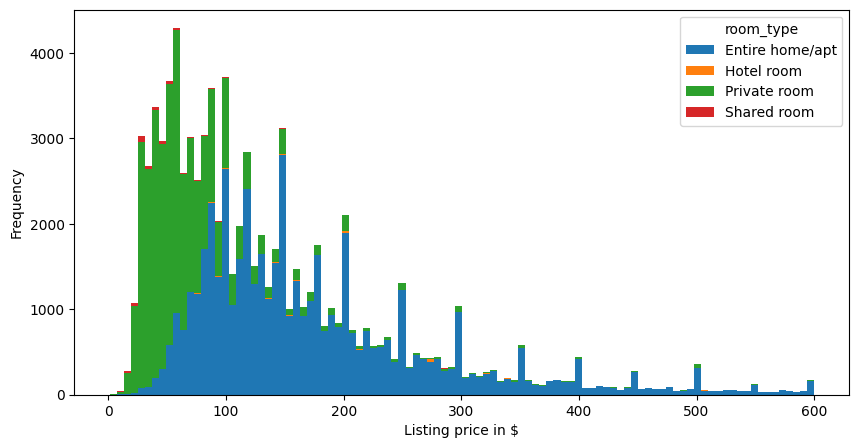

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
df_listings.loc[(df_listings.price <= 600) & (df_listings.price > 0)]\
    .pivot(columns='room_type', values='price')\
    .plot.hist(stacked=True, bins=100, ax=ax)
plt.xlabel('Listing price in $')

Boston Price Ranged From 72 to 1774, average: 576


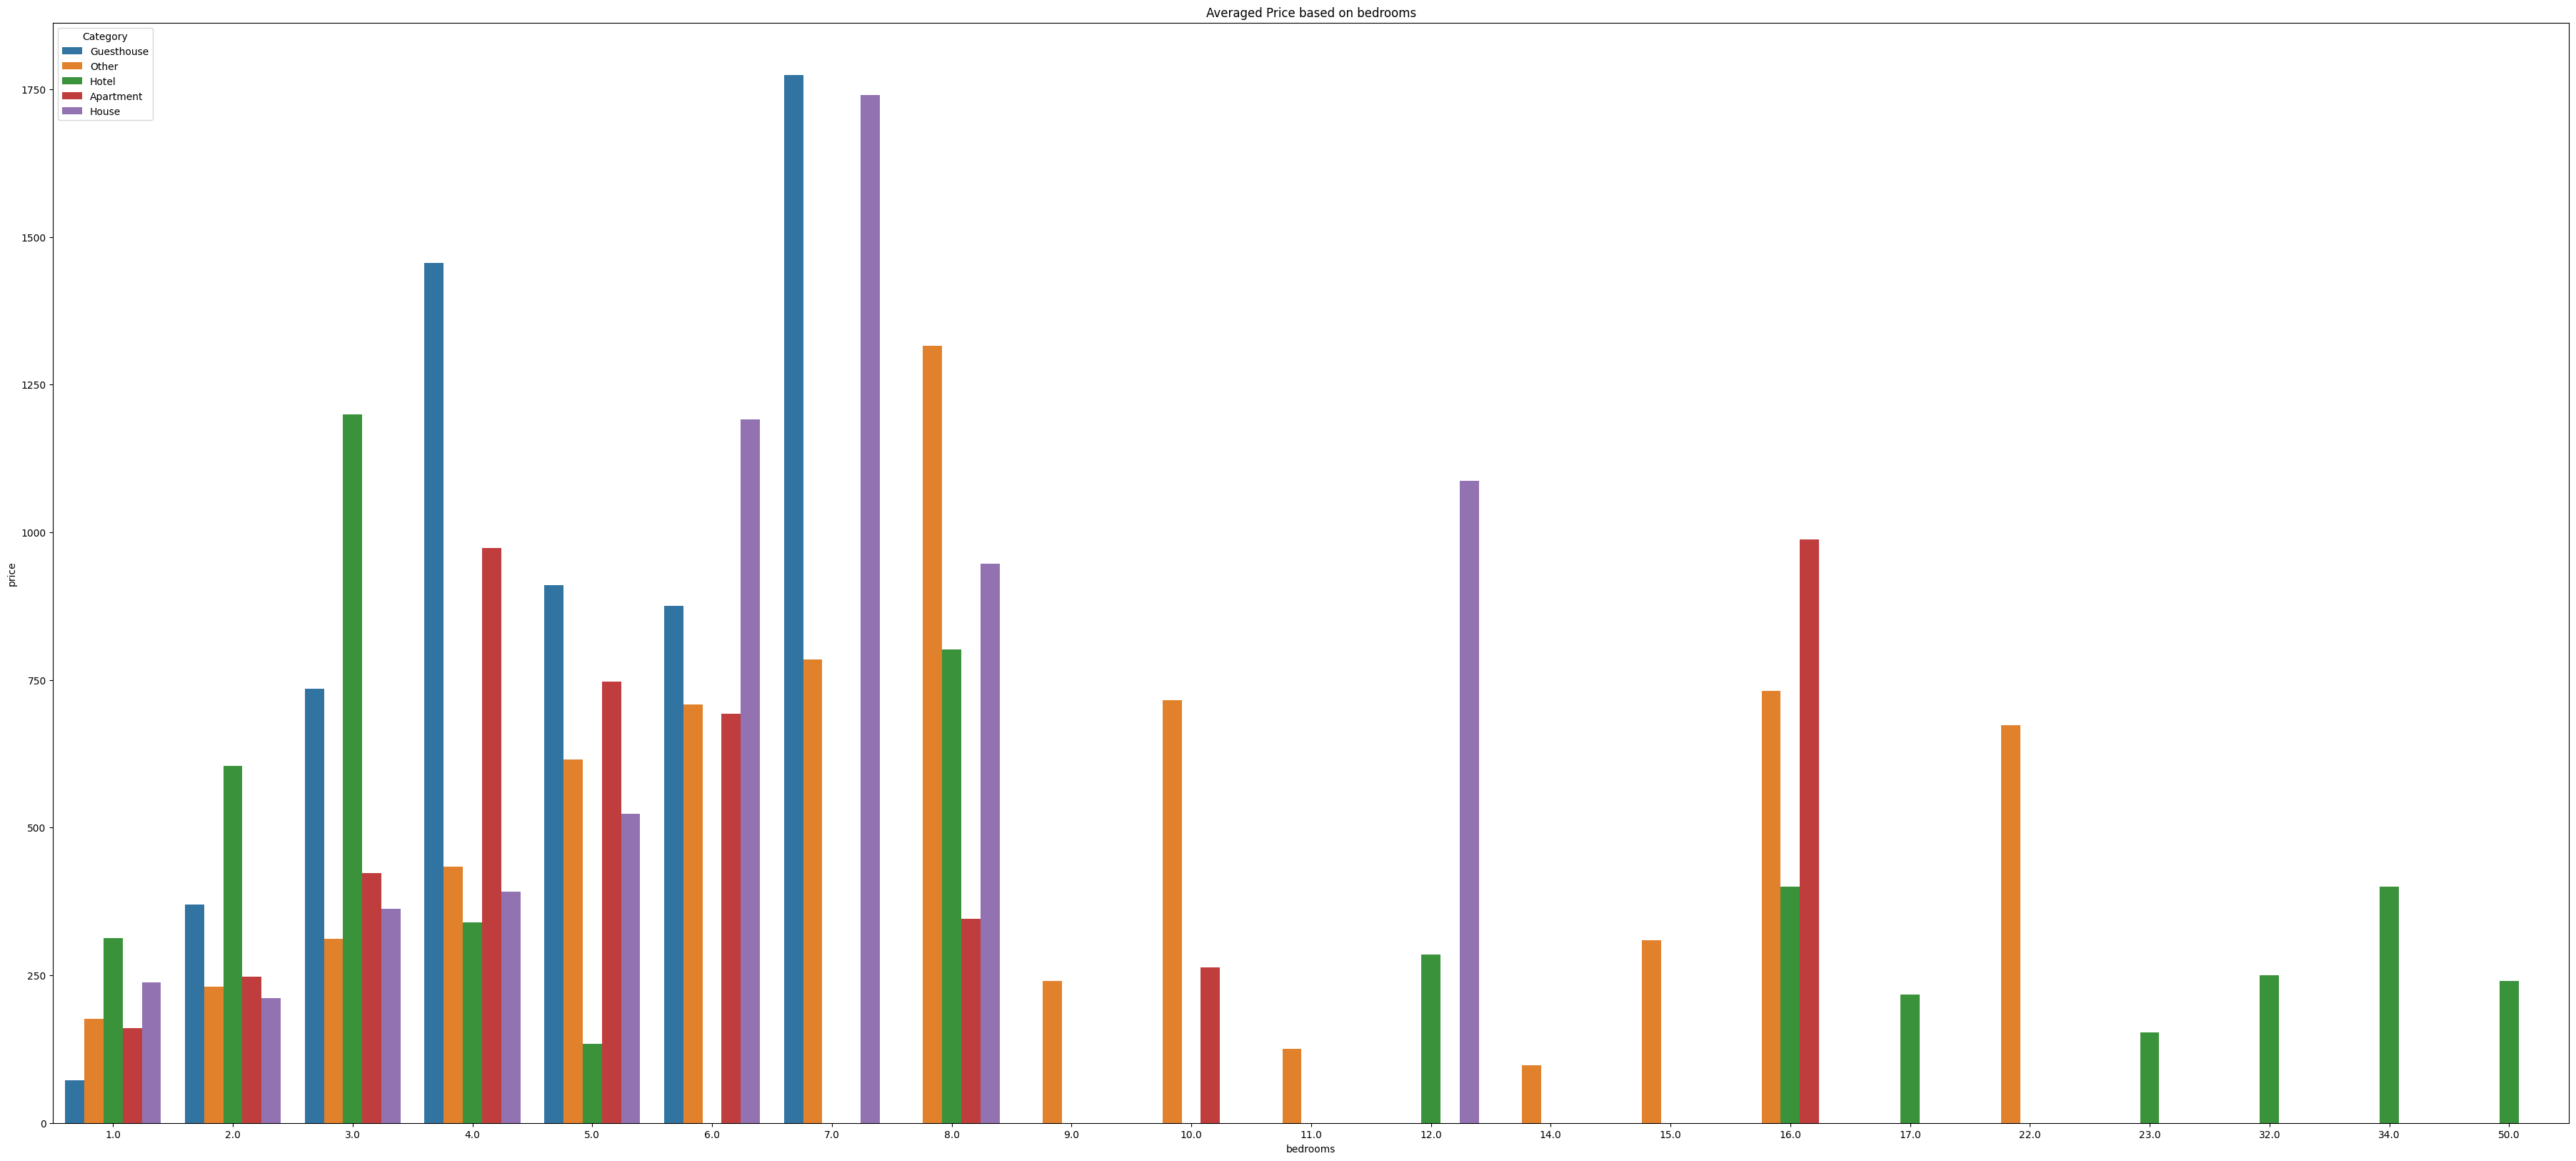

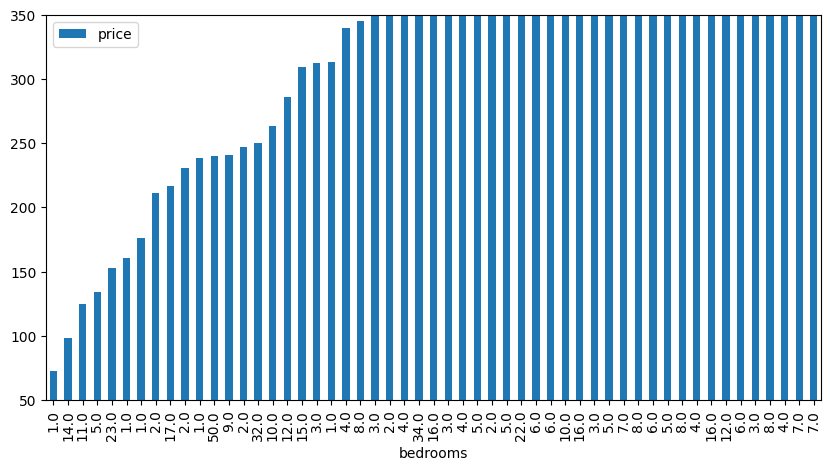

In [390]:
figsize = (100, 20)
x = 'bedrooms'
fig = plt.figure(figsize = figsize)
ax = plot_dist(df_listings,hue="Category", x= x, y = 'price', fig = fig, nrows = 1, ncols = 2, split = False)




* it is interesting to see the number bedrooms and the categories of the rooms, Most bedrooms above 15 rooms fall into hotels and most guest house are around 7 bedrooms. interesting how hotels are most within all the categories

 ## * `3. What are the essential ammenities needed `?

In [27]:
df_listings.amenities = df_listings.amenities.str.replace("[{}]", "").str.replace('"', "")

/Users/user/Airbnb data analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


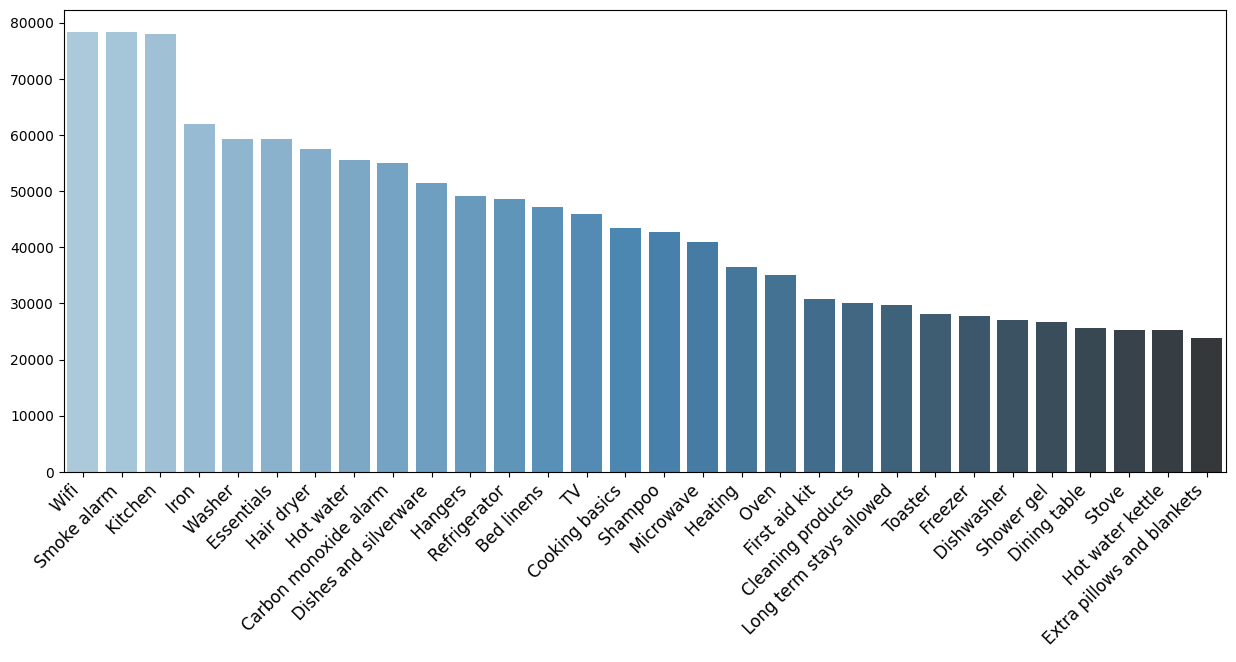

In [28]:

fig, ax = plt.subplots(figsize=(15, 6))

top_30_amenities = pd.Series(np.concatenate(np.array(df_listings['amenities'].map(lambda amns: amns.split(",")))))\
          .value_counts().head(30)

sns.barplot(x=top_30_amenities.index, y = top_30_amenities.values, palette=("Blues_d"))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12);

#  Amenities
* Wifi, Smoke Alarm, kitchen, Iron are most common ammenities.
* We use count vectorizer to turn text into word count vectors that can be used in machine learning models.
* There are much features for amenities. We have to reduce the number of features. It can be done by removing categories that appear fewer than 15% of listings.

In [116]:
cleaned_list  = df_listings.copy()


def day_diff(df):
    '''
    Usage: calculate the day difference using columns "host_since" and "last_scraped"
    Input arguments:
    df  -- a dataframe object
    
    Return: None
    '''
    if ('last_scraped' in df.columns) & ('host_since' in df.columns):
        df['host_days'] = (pd.to_datetime(df['last_scraped']) - pd.to_datetime(df['host_since'])).apply(lambda x: x.days)
    else:
        print('Error: Date column does not exist in the dataset!')

In [117]:
def date2day(x):
    '''
    Usage: return day of the week based on the date provide
    Input arguments:
    x -- a date
    Return: a integer from 1-7 corresponding to Monday through Sunday
    '''
    if isinstance(x, datetime):
        return x.isoweekday()
    else:
        return x

In [119]:

cleaned_list = df_listings.copy()


# convert the availability to booking rate
cleaned_list['booked_365'] = cleaned_list['availability_365'].apply(lambda x: (365 - x)/365*100)

# calculate the day difference based the two dates: host_since and last_scrape
day_diff(cleaned_list)


# convert date to day
cleaned_list['day'] = cleaned_list.last_scraped.apply(date2day)


# create a day factor feature based on the date
cleaned_list = cleaned_list.reset_index().sort_values(by='index').set_index('index')


# drop unnecessary columns in modeling the host booking rate
feature_to_drop = ['id', 'host_id', 'latitude', 'longitude',
                   'host_since', 'last_scraped', 'first_review', 'availability_365']

processed_list = cleaned_list.drop(labels = feature_to_drop, axis = 1)

In [120]:
def engineer_host_response_time(x):
    '''
    Usage: convert host_response_time to ordinal number 
    Input arguments:
    x -- an input string object
    
    Return: an ordinal number corresponding to how fast the host response is.
    '''
    if x == 'within an hour':
        return 1
    elif x == 'within a few hours':
        return 2
    elif x == 'within a day':
        return 3
    elif x == 'a few days or more':
        return 4
    else:
        return x



def engineer_cancellation_policy(x):
    '''
    Usage: convert cancellation_policy to ordinal number 
    Input arguments:
    x -- an input string object
    
    Return: an ordinal number corresponding to how strict the cancellation policy is.
    '''
    if x == 'flexible':
        return 1
    elif x == 'moderate':
        return 2
    elif x == 'strict':
        return 3
    elif x == 'super_strict_30':
        return 4
    else:
        return x


processed_list.host_response_time = processed_list.host_response_time.apply(engineer_host_response_time)
# processed_list.cancellation_policy = processed_list.cancellation_policy.apply(engineer_cancellation_policy)

In [121]:
import re

def process_amenity(df):
    '''
    Usage: process amenity column in the dataframe
    Input: 
    df - the dataframe containing amenities column
    Return: a dictionary containing all unique amenity, 
            with each key linked to a list of dataframe index of row
            containing that amenity
    '''
    if 'amenities' not in df.columns:
        return
    
    listings = list(df['amenities'])
    listing_amenity = dict()
    
    for i, listing in enumerate(listings):
        amenities = listing.split(',')
        for amenity in amenities:
            amenity.replace("[{}]", "").replace('"', "")
            
            listing_amenity.setdefault(amenity, list())
            listing_amenity[amenity].append(i)
    return listing_amenity

def add_new_amenity(df, listing_amenity, new_feature):
    '''
    Usage: add categorical variable of one particular amenity to the dataframe
    Input: 
    df - the dataframe to which you want to add the amenity category variable
    listing_amenity - a dictionary of amenities which contains lists of indexes
    new_feature - the name of amenity category variable 
    Return: None
    '''
    arr = np.zeros(df.shape[0], dtype=int)
    items = listing_amenity[new_feature]
    for item in items:
        arr[item] = 1
    df[new_feature] = arr


# iterate over each amenity and add its categorical dummy variable to the dataframe
listing_amenity = process_amenity(processed_list)
amenity_cat = set(listing_amenity.keys())
amenity_cols = []
for item in amenity_cat:
    amenity_cols.append(item)
    add_new_amenity(processed_list, listing_amenity, item)

/Users/user/Airbnb data analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [395]:
# iterate over each amenity and add its categorical dummy variable to the dataframe
# df_listings.amenities

In [ ]:



from sklearn.preprocessing import LabelEncoder
import pandas as pd



all_labelencoders = {}

cols = ["name","host_location","neighbourhood_cleansed", "property_type", "room_type", "amenities", "bathrooms_text","host_is_superhost",
        "host_has_profile_pic","host_identity_verified","Category","instant_bookable","has_availability"]

for name in cols:
    labelencoder = LabelEncoder()
    all_labelencoders[name] = labelencoder

    labelencoder.fit(processed_list[name] )
    processed_list['labelencoder_' + name] = labelencoder.transform(processed_list[name] )




In [ ]:
p_list  = ['scrape_id', 'listing_url', 'source', 'description','neighborhood_overview', 'picture_url', 'host_url','host_name',
           'host_thumbnail_url','host_picture_url','host_neighbourhood','host_verifications','neighbourhood',
            "host_about","name","host_location","host_response_time","neighbourhood_cleansed", "property_type", "room_type", "amenities", "bathrooms_text" ,"host_response_rate","host_acceptance_rate",'last_review', 'calendar_last_scraped',
            'Category','instant_bookable','has_availability',"neighbourhood_group_cleansed" , "bathrooms" , "calendar_updated", "license" 
            ,"host_is_superhost","host_has_profile_pic","host_identity_verified","neighbourhood_group_cleansed" , "bathrooms" , "calendar_updated", "license"  ,"host_is_superhost","host_has_profile_pic","host_identity_verified",'instant_bookable','has_availability']


processed_list = processed_list.drop(labels = p_list, axis = 1)
# 
processed_list['year'] = pd.DatetimeIndex(processed_list['day']).year
processed_list['month'] = pd.DatetimeIndex(processed_list['day']).month
processed_list['day'] = pd.DatetimeIndex(processed_list['day']).day

processed_list= processed_list.fillna(processed_list.mean())

In [399]:
# count the number of listings for each type of amenities
from tqdm import tqdm
import pprint

amenity_pct = processed_list[amenity_cols].sum(axis = 0).sort_values(ascending = True)/processed_list.shape[0]*100
amenity_pct = amenity_pct.reset_index()
amenity_pct.rename(columns = {'index': 'amenity', 0: 'PCT'}, inplace = True)

df_listings.amenities = df_listings.amenities.str.replace("[{}]", "").str.replace('"', "")

# calculate the price difference between the listing w specific amenity and listing w/o amenity

top_30_amenities = pd.Series(np.concatenate(np.array(df_listings['amenities'].map(lambda amns: amns.split(",")))))\
          .value_counts()[:30]

am_price = pd.DataFrame(data= np.zeros((len(top_30_amenities), 2)), 
                index = top_30_amenities.index.to_list(), columns = ['price_wo_amenity', 'price_w_amenity'])


for col in tqdm(top_30_amenities.index.to_list()):
    if col in processed_list.columns:
        price_wo_amenity = processed_list[processed_list[col] == 0]['price'].mean()
        price_w_amenity = processed_list[processed_list[col] == 1]['price'].mean()
        am_price.loc[col,'price_wo_amenity'] = price_wo_amenity
        am_price.loc[col,'price_w_amenity'] = price_w_amenity
        am_price.loc[col,'price_difference'] = price_w_amenity - price_wo_amenity
        am_price.loc[col,'%price_difference'] = (price_w_amenity - price_wo_amenity)/price_wo_amenity
        am_price.loc[col,'%price_abs_difference'] = np.abs((price_w_amenity - price_wo_amenity)/price_wo_amenity)
    else:
        continue
am_price = am_price.sort_values(by='%price_abs_difference', ascending = True)

# calculate the total number of amenities, store it into a new column
# processed_list['Total_Amenities'] = processed_list.amenities.apply(lambda x: x.count(',')-1 )
# processed_list = processed_list.drop(labels = 'amenities', axis = 1)

In [398]:

# calculate the total number of amenities, store it into a new column
processed_list['Total_Amenities'] = processed_list.labelencoder_amenities.copy()


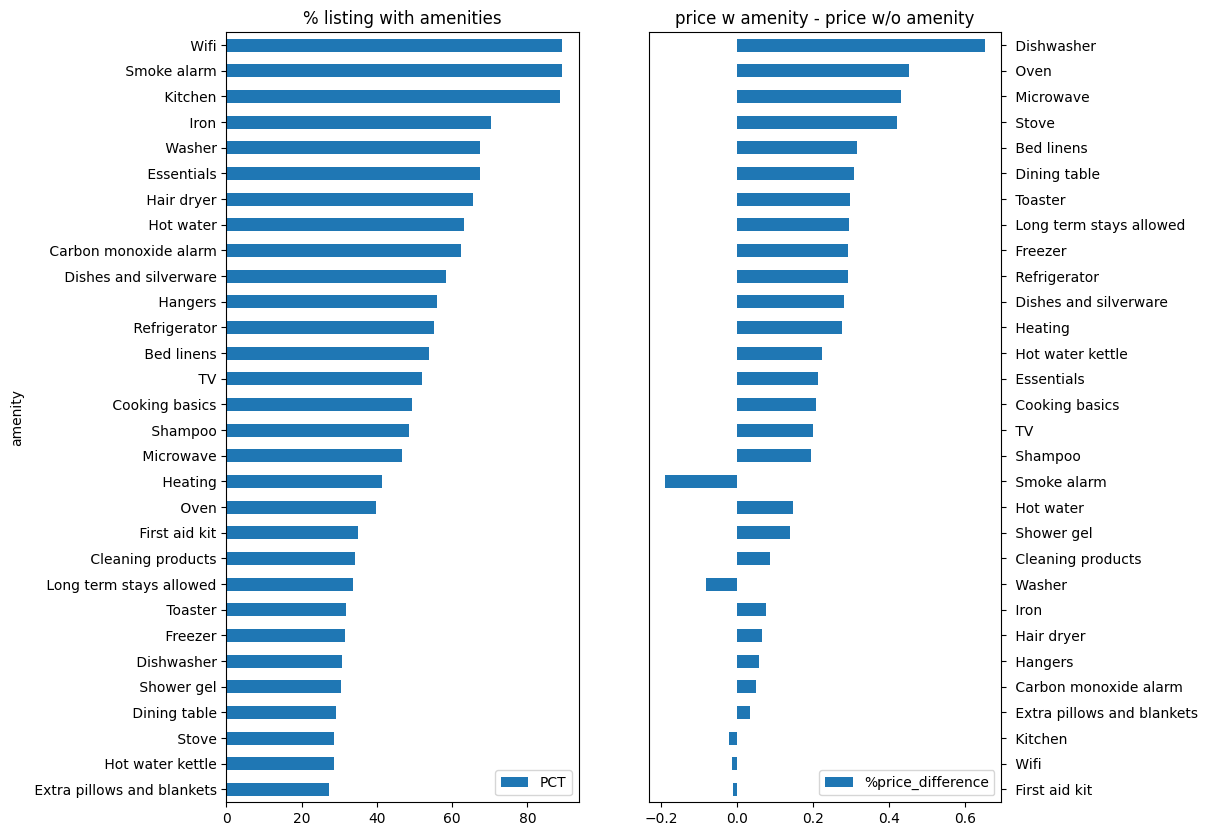

In [411]:
# plot the distribution of amenity type, and the price difference
figsize = (10, 10)
fig = plt.figure(figsize = figsize)
ax = fig.add_subplot(1, 2, 1) 
amenity_pct = amenity_pct.sort_values(by = "PCT", ascending = True).head(30)
ax = amenity_pct.plot.barh(x='amenity', y='PCT', ax =ax, title = '% listing with amenities')
#fig = ax.get_figure()
ax = fig.add_subplot(1, 2, 2) 
ax = am_price.plot.barh(y = '%price_difference', ax = ax, title = 'price w amenity - price w/o amenity')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# Discussion

The amenity-type distribution (left panel) shows that the top 3 common amenities among the listings are Wifi, Smoke Alarm, and kitchen, with very few listings with parking Stoves, Hot water kettle and Extra Pillows and Blankets, etc. On the one hand, by comparing the average price difference between the listing with a particular amenity and those without, we can see that amenities such as  doorman service, TV, Airconditioning add significant values to the homestay (We need to be careful with very popular/rare amenties, such as Hair Dryer, since either the listings with or without these amenities may not accumlate enough statistics to make an inference). On the other hand, we can also see that Washer and smoke alarm significantly depreciate the listing value.

In modeling the listing price, I will select amenities that significantly add/reduce the listing price as part of features.

# `4. What is the correlation of their remarks with the reviews `

In [429]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StructType, StructField, StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import col



from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()


df_reviews_2 = pd.read_csv("/Users/user/Downloads/reviews 2.csv")
new_df = pd.merge(df_listings, df_reviews_2,  how='inner', left_on=['host_id'], right_on = ['reviewer_id'])

#df_seed["Polarized"] = df_seed["comments"].apply(lambda  x: sentiment.polarity_scores(str(x)))


# Create a Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()



def analyze_sentiment(text):
    sentiment_scores = sentiment.polarity_scores(text)
    return sentiment_scores['compound']



analyze_sentiment = spark.udf.register("analyze_sentiment", analyze_sentiment)

def perform_sentiment_analysis(input_df, review_column,host_column):
    """
    Perform sentiment analysis on a specific column of a Pandas DataFrame using Spark.

    Args:
        input_df (pd.DataFrame): The input Pandas DataFrame.
        input_column (str): The name of the column to analyze.

    Returns:
        pd.DataFrame: A Pandas DataFrame with sentiment analysis results.
    """
    # Convert the input Pandas DataFrame to a Spark DataFrame
    spark_df = spark.createDataFrame(input_df)

    # Apply sentiment analysis using the UDF
    result_pandas_df = spark_df.withColumn("review_sentiment",analyze_sentiment(col(review_column))).withColumn("host_about_sentiment",analyze_sentiment(col(host_column)))



    result_pandas_df = result_pandas_df.toPandas()

    #print(result_pandas_df)

    return result_pandas_df


# Perform sentiment analysis on the "text" column
result_pandas_df = perform_sentiment_analysis(new_df, "comments","host_about")


# Show the result as a Pandas DataFrame
#print(result_pandas_df)

# Stop the Spark session
spark.stop()

/Users/user/Airbnb data analysis/venv/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)
23/11/02 11:40:36 WARN TaskSetManager: Stage 0 contains a task of very large size (1598 KiB). The maximum recommended task size is 1000 KiB.


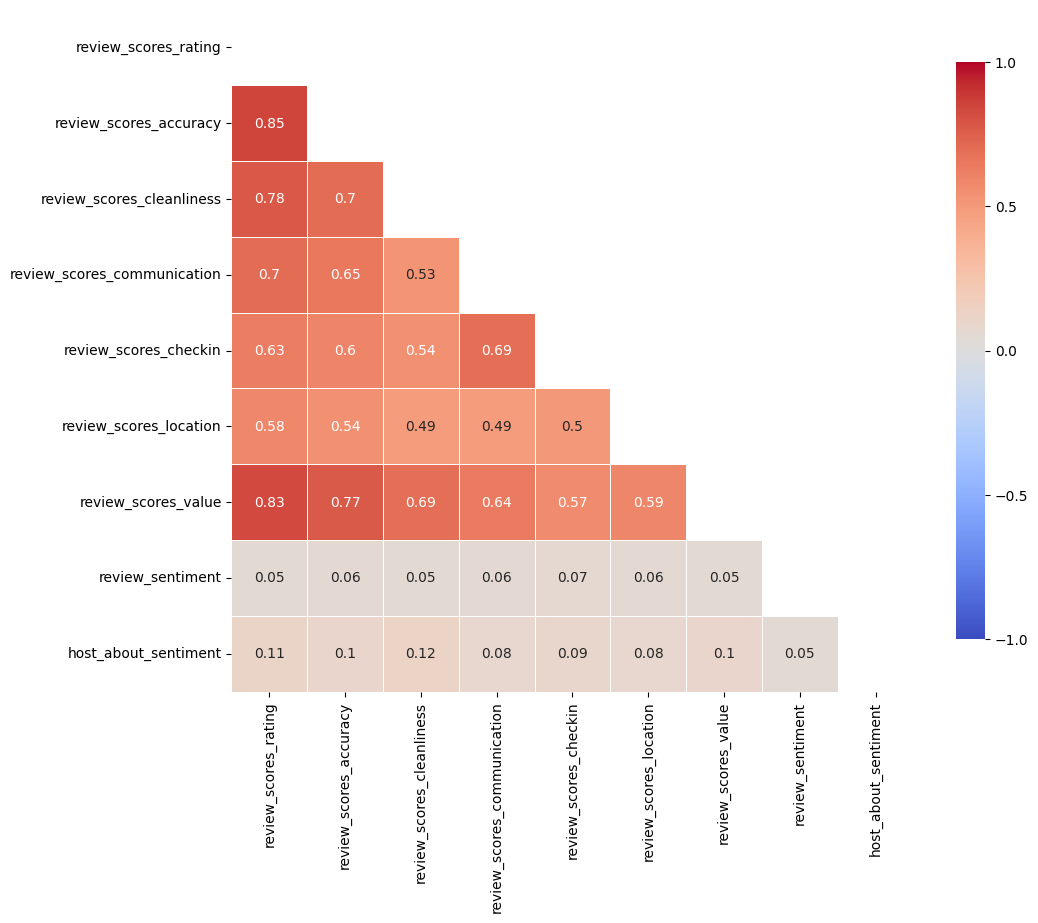

In [432]:
review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_communication', 'review_scores_checkin', 'review_scores_location', 'review_scores_value',"review_sentiment","host_about_sentiment"]

result_pandas_df.review_sentiment = result_pandas_df.review_sentiment.astype(float)
result_pandas_df.host_about_sentiment = result_pandas_df.host_about_sentiment.astype(float)

annotated_heatmap(result_pandas_df, review_columns, figsize=(11, 15))

# * The sentiment of the host reviews has a low correlation with the review scores, this will mean we will need to dig deeper into the reviews and figure out why it appears so. 

#   * `5. What Features affect price the most and what features affect the average price over time. `

In [174]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, make_scorer, r2_score, mean_squared_error
# from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from datetime import datetime
# from helper import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option("max_columns", None)


# combine price and cleaning fee to total price
data = processed_list.copy()
# drop unwanted features
drop_cols = ['host_days']
data.drop(labels = drop_cols, axis = 1, inplace = True)
# drop unwanted amenity dummy variables
amenity_keep_cols = ['WasherDryer', 'Doorman', 'TV', 'AirConditioning', 'FamilyKidFriendly', 'Kitchen',
                     'CableTV', 'Dryer', 'Washer', 'HairDryer'] 
amenity_drop_cols = []
for col in amenity_cols:
    if col not in amenity_keep_cols:
        amenity_drop_cols.append(col)
data.drop(labels = amenity_drop_cols, axis = 1, inplace = True)
## apply feature scaling
scaler = StandardScaler()
data_transformed = pd.DataFrame(data = scaler.fit_transform(data), index = data.index, columns = data.columns)
X_transformed = data_transformed.drop(labels = ['price'], axis = 1)
y_transformed = data_transformed[['price']].iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.3, random_state = 42)

# specify 'GB' to use gradient-boost regressor, or 'RF' random forest regressor
method = 'GB'
criterion = ['mse']
# After trying different parameter sets, 
# I found the gradient-boosting regressor performs the best with the following parameters.
# Random forest regressor can easily yield to overfitting.
# Feel free to try different parameters. 
n_estimators = [4000]
max_features = [10]
max_depth = [6]
min_samples_leaf = [2]
# lower learning rate prevents overfitting
learning_rate = 0.001 
# number of fold in the training
cv = 3

    
def GridSearch(X_train, X_test, y_train, y_test, criterion = ['mse'], n_estimators = [300, 600],
                  method = 'GBDT', learning_rate = 0.5, validate = False, cv = 5,
                  max_features = ['auto'], max_depth = [10, 20, 40], min_samples_leaf = [2,4], n_jobs = -1):
    '''
    Usage: use gridsearch to find optimal parameters for the random forest (RF) regressor.
    Input: training and testing sets from X and y variables
    Output: the best regressor
    '''
    
    if method == 'GB':
        clf = GradientBoostingRegressor(random_state=42, learning_rate = learning_rate)
    elif method == 'RF':
        clf = RandomForestRegressor(random_state=42, n_jobs = n_jobs)
    else:
        clf = RandomForestRegressor(random_state=42, n_jobs = n_jobs)
        
    parameters = {'criterion': criterion,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'min_samples_leaf':min_samples_leaf,
                  'max_features':max_features
                 }
    
    #Use gridsearch to find the best-model parameters.
    grid_obj = GridSearchCV(clf, parameters, cv = cv)
    grid_fit = grid_obj.fit(X_train, y_train)
    
    #obtaining best model, fit it to training set
    best_clf = grid_fit.best_estimator_
    best_clf.fit(X_train, y_train)

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(X_train)
    print('The training MSE Score is', mean_squared_error(y_train, best_train_predictions))
    print('The training R2 Score is', r2_score(y_train, best_train_predictions))
  
    if validate:
        best_test_predictions = best_clf.predict(X_test)
        print('The testing MSE Score is', mean_squared_error(y_test, best_test_predictions))
        print('The testing R2 Score is', r2_score(y_test, best_test_predictions))
    return best_clf








best_clf = GridSearch(X_train, X_test, y_train, y_test, method = method, learning_rate = learning_rate, \
                      criterion = criterion, n_estimators = n_estimators, validate = True, cv = cv, \
                      max_features = max_features, max_depth = max_depth, min_samples_leaf = min_samples_leaf)

y_pred = best_clf.predict(X_test)

r_squared = r2_score(y_test, y_pred)
root_mse = np.sqrt(mean_squared_error(y_test, y_pred))
importances = best_clf.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})

The training MSE Score is 0.3468982417453134
The training R2 Score is 0.6215010635731998
The testing MSE Score is 1.0122981190658307
The testing R2 Score is 0.15268217151675956


In [172]:
best_clf

In [435]:
# perform k-fold cross-validation
scorer = make_scorer(r2_score)
clf_scores = cross_val_score(best_clf, X_test, y_test,
                             scoring= scorer, cv=10)
print('The average R2 score on the test set: ', clf_scores.mean())

The average R2 score on the test set:  0.6430742998478628


In [437]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, make_scorer, r2_score, mean_squared_error
# from mpl_toolkits.basemap import Basemap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from datetime import datetime
# from helper import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option("max_columns", None)


# combine price and cleaning fee to total price
data = processed_list.copy()
# drop unwanted features
drop_cols = ['host_days']
data.drop(labels = drop_cols, axis = 1, inplace = True)
# drop unwanted amenity dummy variables
amenity_keep_cols = ['WasherDryer', 'Doorman', 'TV', 'AirConditioning', 'FamilyKidFriendly', 'Kitchen',
                     'CableTV', 'Dryer', 'Washer', 'HairDryer'] 
amenity_drop_cols = []
for col in amenity_cols:
    if col not in amenity_keep_cols:
        amenity_drop_cols.append(col)
data.drop(labels = amenity_drop_cols, axis = 1, inplace = True)
## apply feature scaling
scaler = StandardScaler()
data_transformed = pd.DataFrame(data = scaler.fit_transform(data), index = data.index, columns = data.columns)
X_transformed = data_transformed.drop(labels = ['price'], axis = 1)
y_transformed = data_transformed[['price']].iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.3, random_state = 42)

# specify 'GB' to use gradient-boost regressor, or 'RF' random forest regressor
method = 'GB'
criterion = ['mse']
# After trying different parameter sets, 
# I found the gradient-boosting regressor performs the best with the following parameters.
# Random forest regressor can easily yield to overfitting.
# Feel free to try different parameters. 
n_estimators = [4000]
max_features = [10]
max_depth = [6]
min_samples_leaf = [2]
# lower learning rate prevents overfitting
learning_rate = 0.001 
# number of fold in the training
cv = 3

    
def GridSearch(X_train, X_test, y_train, y_test, criterion = ['mse'], n_estimators = [300, 600],
                  method = 'GBDT', learning_rate = 0.5, validate = False, cv = 5,
                  max_features = ['auto'], max_depth = [10, 20, 40], min_samples_leaf = [2,4], n_jobs = -1):
    '''
    Usage: use gridsearch to find optimal parameters for the random forest (RF) regressor.
    Input: training and testing sets from X and y variables
    Output: the best regressor
    '''
    
    if method == 'GB':
        clf = GradientBoostingRegressor(random_state=42, learning_rate = learning_rate)
    elif method == 'RF':
        clf = RandomForestRegressor(random_state=42, n_jobs = n_jobs)
    else:
        clf = RandomForestRegressor(random_state=42, n_jobs = n_jobs)
        
    parameters = {'criterion': criterion,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'min_samples_leaf':min_samples_leaf,
                  'max_features':max_features
                 }
    
    #Use gridsearch to find the best-model parameters.
    grid_obj = GridSearchCV(clf, parameters, cv = cv)
    grid_fit = grid_obj.fit(X_train, y_train)
    
    #obtaining best model, fit it to training set
    best_clf = grid_fit.best_estimator_
    best_clf.fit(X_train, y_train)

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(X_train)
    print('The training MSE Score is', mean_squared_error(y_train, best_train_predictions))
    print('The training R2 Score is', r2_score(y_train, best_train_predictions))
  
    if validate:
        best_test_predictions = best_clf.predict(X_test)
        print('The testing MSE Score is', mean_squared_error(y_test, best_test_predictions))
        print('The testing R2 Score is', r2_score(y_test, best_test_predictions))
    return best_clf








best_clf = GridSearch(X_train, X_test, y_train, y_test, method = method, learning_rate = learning_rate, \
                      criterion = criterion, n_estimators = n_estimators, validate = True, cv = cv, \
                      max_features = max_features, max_depth = max_depth, min_samples_leaf = min_samples_leaf)

y_pred = best_clf.predict(X_test)

r_squared = r2_score(y_test, y_pred)
root_mse = np.sqrt(mean_squared_error(y_test, y_pred))
importances = best_clf.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})

The training MSE Score is 0.3273647267179351
The training R2 Score is 0.6428139841153793
The testing MSE Score is 1.0137183945744512
The testing R2 Score is 0.15149336681867043


<AxesSubplot:ylabel='feature'>

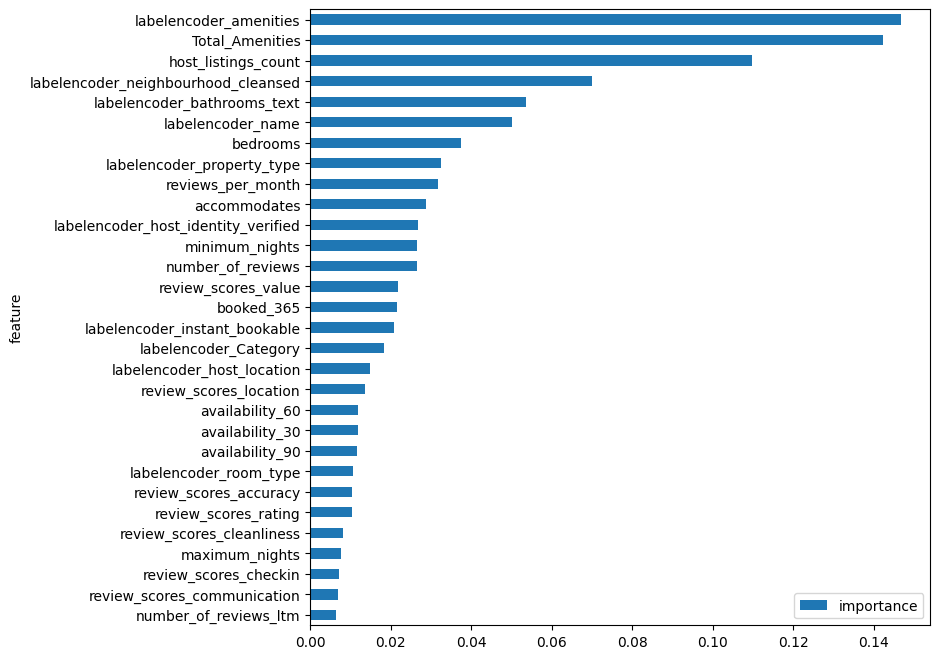

In [438]:
# plot top 20 important features
figsize= (8, 8)
tree_result.sort_values(by='importance',ascending=True)[-30:].plot(x='feature', y='importance', 
                                                                    kind='barh', figsize = figsize)

Discussion

The figure above shows top 10 important features in descending order. General speaking, numerical features, such as the number of rooms, beds, bathrooms and the number of guest, are most significant. For dummy variables, room type of "Entire home/apt", "Private room", and amenity of "AirConditioning", "CableTV" add significant values to the listing compared to other categories. Surprisely, the daily rate factor and neighbourhood are relatively less significant.

 # * `7. Which Features affect the book rate the most ` 

In [177]:
# select features used for modeling
data = processed_list.copy()
# drop_cols = ['reviews_per_month', 'calculated_host_listings_count','review_scores_accuracy',
#              'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
#              'review_scores_value']

data.drop(labels = drop_cols, axis = 1, inplace = True)

# drop unwanted amenity dummy variables
amenity_keep_cols = ['WasherDryer', 'Doorman', 'TV', 'AirConditioning', 'FamilyKidFriendly', 'Kitchen',
                     'CableTV', 'Dryer', 'Washer', 'HairDryer'] 
amenity_drop_cols = []
for col in amenity_cols:
    if col not in amenity_keep_cols:
        amenity_drop_cols.append(col)
data.drop(labels = amenity_drop_cols, axis = 1, inplace = True)

## apply feature scaling
scaler = StandardScaler()
data_transformed = pd.DataFrame(data = scaler.fit_transform(data), index = data.index, columns = data.columns)
X_transformed = data_transformed.drop(labels = ['booked_365'], axis = 1)
y_transformed = data_transformed[['booked_365']].iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size = 0.3, random_state = 42)

criterion = ['mse']
method = 'RF' 
n_estimators =  [200, 400]
max_features = [30, 50, 80] 
max_depth = [10, 20, 40] 
min_samples_leaf = [2,4]
learning_rate = 0.001

best_clf = GridSearch(X_train, X_test, y_train, y_test, method = method, learning_rate = learning_rate, \
                         criterion = criterion, n_estimators = n_estimators, \
                         max_features = max_features, max_depth = max_depth, min_samples_leaf = min_samples_leaf)

/Users/user/Airbnb data analysis/venv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
120 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/user/Airbnb data analysis/venv/lib/python3.7/site-packages/joblib/_parallel_backends.py", line 273, in _wrap_func_call
    return func()
  File "/Users/user/Airbnb data analysis/venv/lib/python3.7/site-packages/joblib/parallel.py", line 590, in __call__
    for func, args, kwargs in self.items]
  File "/Users/user/Airbnb data analysis/venv/lib/python3.7/site-packages/joblib/

The training MSE Score is 0.06996546870629984
The training R2 Score is 0.9299606960641625


<AxesSubplot:ylabel='feature'>

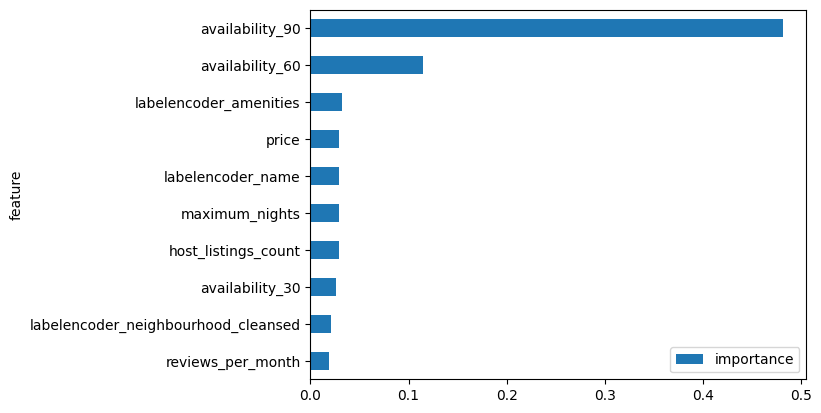

In [178]:

importances = best_clf.feature_importances_ 
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=True)[-10:].plot(x='feature', y='importance', kind='barh')

## Conclusion
The result from above indicate top 10 attributes that AirBnB guests value when choosing the homestay among the listings. In general, they care about the following aspects:

availability;
amenities;
ratings on the listing, including the number of review, and the overall review score;
listing price;
neighbourhood_cleansed;

In summary, guests tend to choose the listing with more reviews and good rating score. In addtion, they also prefer experienced hosts, and appreciate a smooth communication with the host. Last but not least, price is the key factor that finalizes guests' decision.

 # `8. Which month is the most expensive month to travel on ` 

In [262]:
df_calendar = pd.read_csv('/Users/user/Downloads/calendar.csv.gz', low_memory=False)

In [263]:
print(f"There are {df_calendar.listing_id.nunique()} of unique listings")

There are 87946 of unique listings


In [264]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32100363 entries, 0 to 32100362
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.7+ GB


In [412]:
def clean_calendar(df):
    """Remove the dollar sign in front of price and adjusted_price, Convert the categorical varaible into binary variable,
       and turn date to datetime object.

       inputs:
           df: A pandas dataframe object
       returns:
           df: A cleaned version of dataframe
    """
    calendar = df.copy()

    calendar['price'] = calendar['price'].str.replace(',', '')
    calendar['price'] = calendar['price'].str.replace('$', '').astype(float)

    calendar['adjusted_price'] = calendar['adjusted_price'].str.replace(',', '')
    calendar['adjusted_price'] = calendar['adjusted_price'].str.replace('$', '').astype(float)


    calendar['bookings'] = calendar['available'].map(lambda x: 0 if x == 't' else 1)

    calendar['date'] = pd.to_datetime(calendar['date'])
    calendar = calendar[calendar.date != '2020-05-05']
    calendar['month'] = calendar['date'].dt.strftime('%B')

    return calendar


cleaned_calendar = clean_calendar(df_calendar)

In [413]:
cleaned_calendar.head(5)

listing_id       date available  price  adjusted_price  minimum_nights  \
0       13913 2023-09-06         f   79.0            79.0             1.0   
1       13913 2023-09-07         f   79.0            79.0             1.0   
2       13913 2023-09-08         f   79.0            79.0             1.0   
3       13913 2023-09-09         f   79.0            79.0             1.0   
4       13913 2023-09-10         f   79.0            79.0             1.0   

   maximum_nights  bookings      month  
0            29.0         1  September  
1            29.0         1  September  
2            29.0         1  September  
3            29.0         1  September  
4            29.0         1  September

In [414]:
num_bookings = cleaned_calendar.groupby(['listing_id']).bookings.count()
num_bookings[num_bookings > 365].head()

listing_id
2456014     366
3428996     366
4892143     366
5122865     366
10350394    366
Name: bookings, dtype: int64

In [415]:
avg_booked_rate = cleaned_calendar.groupby('date')['bookings'].mean()

In [416]:
avg_booked_rate.tail()

date
2024-09-01    0.712301
2024-09-02    0.712619
2024-09-03    0.712517
2024-09-04    0.712596
2024-09-05    0.843342
Name: bookings, dtype: float64

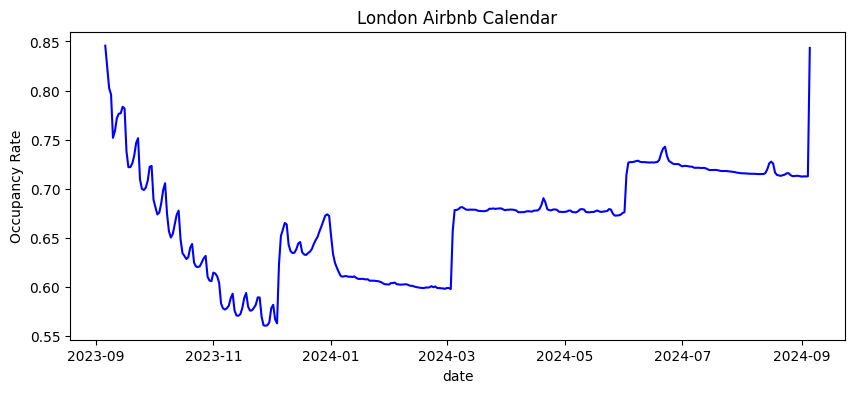

In [417]:
fig, ax = plt.subplots(figsize=(10,4))
lineplot = sns.lineplot(color='b',
             ax=ax,
             data = avg_booked_rate)
ax.set_title('London Airbnb Calendar')
ax.set_ylabel('Occupancy Rate')

lineplot.figure.savefig('images/calendar.png', dpi=800);

In [418]:
monthly_price = cleaned_calendar.groupby(['date'], sort=False)['price'].mean()
monthly_price_df = monthly_price.to_frame().reset_index()
monthly_price_df['month'] = monthly_price_df['date'].dt.strftime('%B')
#monthly_price_df['day'] = monthly_price_df['date'].dt.strftime('%A')

In [419]:
monthly_price_df = monthly_price_df[monthly_price_df.price > 105]

In [421]:
monthly_price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    366 non-null    datetime64[ns]
 1   price   366 non-null    float64       
 2   month   366 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 11.4+ KB


## Which month is more expensive to travel on?

The average prices tends to increases along the year except for September 
which is signifactly lower than the other months.
In comparsion to the 'Number of reviews' plots in next section,
the pattern is similar except for December.
December is more expensive compared to the other months. 
This may be because december is the holiday season and people are more likely to travel. 
September is the cheapest month to make a booking in Airbnb, maybe because it's closer to vacation period.

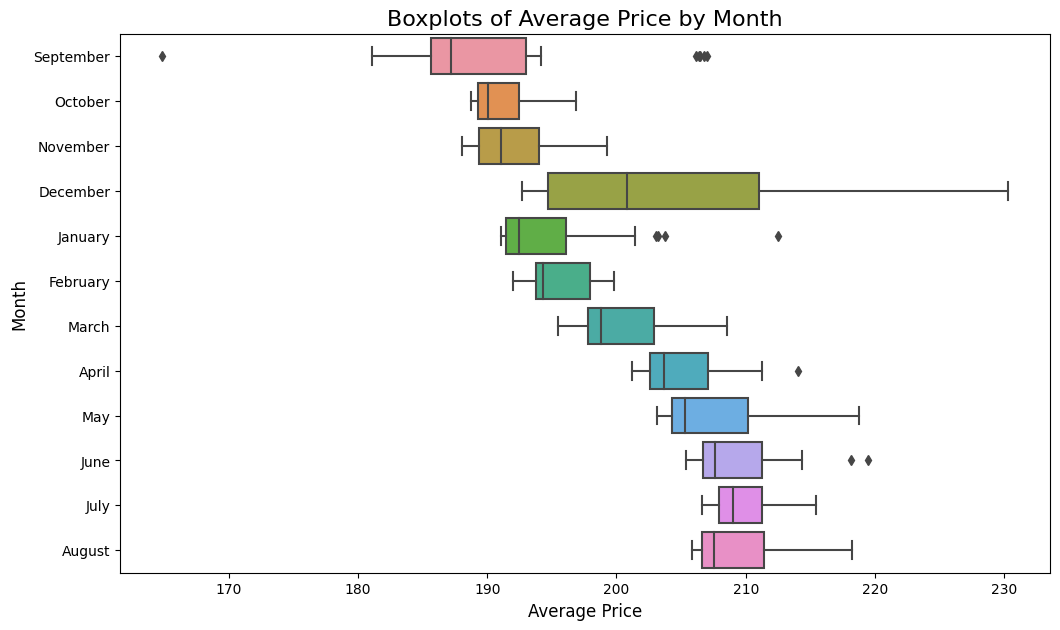

In [425]:
fig, ax = plt.subplots(figsize=(12, 7))
monthly_boxplot = sns.boxplot(data=monthly_price_df, x= monthly_price_df.price, y= monthly_price_df.month)
ax.set_xlabel('Average Price', fontsize=12)
ax.set_ylabel('Month', fontsize=12)
ax.set_title('Boxplots of Average Price by Month', fontsize=16)
fig.savefig('images/boxplot_price.png', dpi=800);

#  * `9. How is the demand for Airbnb changing in London and the number of reviews across the years. `

In [258]:

def clean_reviews(viz_pack='sns',path='/Users/user/Downloads/reviews.csv'):
    """Clean the reviews dataset for easier visualization

       inputs::
            viz_pacl: string to indicate which vizualization package  to use
       returns:
           df_reviews: A cprocessed version of reviews.csv dataset based on vizualization package
        """


    df_reviews = load_csv(path)

    if viz_pack == 'sns':
        df_reviews['datnum'] = dates.datestr2num(df_reviews['date'])
        df_reviews['date'] = pd.to_datetime(df_reviews['date'])
        df_reviews['year'] = df_reviews['date'].dt.year
        df_reviews = df_reviews.groupby(['date','datnum'])['listing_id'].count()
        df_reviews = df_reviews.to_frame().reset_index()

    if viz_pack == 'plotly':
        df_reviews = df_reviews.groupby(['date'])['listing_id'].count()
        df_reviews = df_reviews.to_frame().reset_index()
        df_reviews['date'] = pd.to_datetime(df_reviews['date'])
        df_reviews['year'] = df_reviews['date'].dt.year
        df_reviews.index = df_reviews['date']
        df_reviews = df_reviews.rename(columns={'listing_id': 'number_of_reviews'})

    return df_reviews

In [259]:
df_reviews = clean_reviews()

In [260]:
df_reviews.head()

date   datnum  listing_id
0 2009-12-21  14599.0           1
1 2010-04-14  14713.0           1
2 2010-05-09  14738.0           1
3 2010-05-15  14744.0           1
4 2010-05-23  14752.0           1

In [261]:
df_reviews.tail()

date   datnum  listing_id
4644 2023-09-02  19602.0         705
4645 2023-09-03  19603.0        1186
4646 2023-09-04  19604.0         638
4647 2023-09-05  19605.0         375
4648 2023-09-06  19606.0         167

In [285]:
num_reviews_2020 = df_reviews[(df_reviews.date >= "2020-01-01") &
                                  (df_reviews.date <= "2020-12-31")]

In [286]:
num_reviews_2021 = df_reviews[(df_reviews.date >= "2021-01-01") &
                                  (df_reviews.date <= "2021-12-31")]

In [287]:
num_reviews_2022 = df_reviews[(df_reviews.date >= "2022-01-01") &
                                  (df_reviews.date <= "2022-12-31")]

In [288]:
num_reviews_2023 = df_reviews[(df_reviews.date >= "2023-01-01") &
                                  (df_reviews.date <= "2023-12-31")]

In [309]:
num_reviews_2023

date   datnum  listing_id  numeric_date
4400 2023-01-01  19358.0        1915         19358
4401 2023-01-02  19359.0        2053         19359
4402 2023-01-03  19360.0        1198         19360
4403 2023-01-04  19361.0         952         19361
4404 2023-01-05  19362.0         839         19362
...         ...      ...         ...           ...
4644 2023-09-02  19602.0         705         19602
4645 2023-09-03  19603.0        1186         19603
4646 2023-09-04  19604.0         638         19604
4647 2023-09-05  19605.0         375         19605
4648 2023-09-06  19606.0         167         19606

[249 rows x 4 columns]

In [366]:
import statsmodels 



def review_plot(data, major_format,y, filename, xlabel, title, xlim=None, figsize=(8, 5)):
    """Plot the number of reviews for listings and save the figure

    Argument:
    =========
        data: pandas dataframe
        major_format: func object, formattor function
        filename: str, to save the graph
        xlabel: str
        title: str
        xlim: the x-axis ticks limits
    """


    # data.date = pd.to_numeric(data.date)  #np.asarray(x).astype(float)

        # Convert 'date' column to numerical representation
    # data['numeric_date'] = (data['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
    

    fig, ax = plt.subplots(figsize=(8, 5))
    reviews_plot = sns.regplot(x='datnum', y=y, data=data, ax=ax, lowess=True,
                               scatter_kws={"color": "#43a2ca", "alpha": 0.4},line_kws={"color": "red"})
    ax.set_xlim(xlim)
    ax.xaxis.set_major_formatter(major_format)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Number of reviews for unqiue listings')
    fig.tight_layout()

    reviews_plot.figure.savefig(f"./images/{filename}", dpi=800);

    return reviews_plot


# How is the demand for Airbnb changing in London?

There is no available data on the number of bookings over the years. 
Instead we estimate the demand by looking at the number of reviews across years.
According to Inside Airbnb, around 50% of the guests leave reviews to listings, so the number of reviews is a good estimator of the demand.
The "Number of reviews across years" graph shows an upward trend of the number of reviews. 
It also shows seasonal pattern with some months has reviews less than the others. 
The other  graphs show monthly reviews from 2020 and 2023. Both graphs show deamand peaked at around August and slowly decreasing until the end of the year.

it is quite interesting that  the covid pandemic also affected demand for airbnb

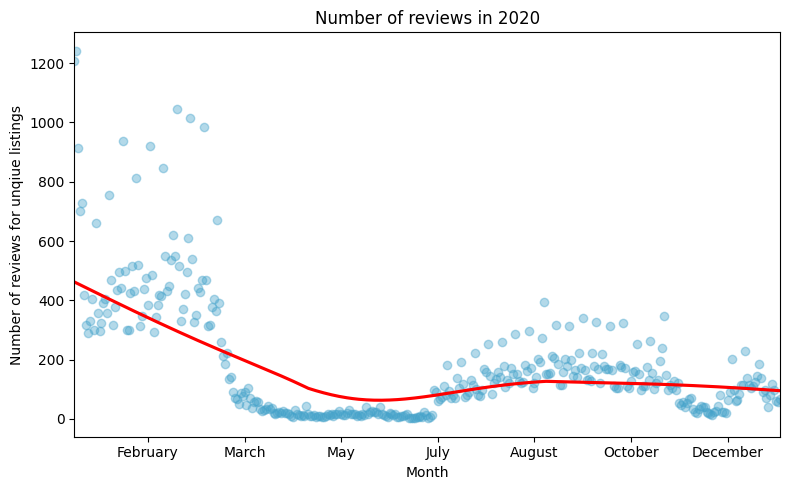

In [382]:
reviews_plot = review_plot(num_reviews_2020, fake_month, 'listing_id', 'review_2020.png', 'Month',
                           'Number of reviews in 2020', xlim=(18262.0, 18627.0))

<AxesSubplot:title={'center':'Number of reviews in 2021'}, xlabel='Month', ylabel='Number of reviews for unqiue listings'>

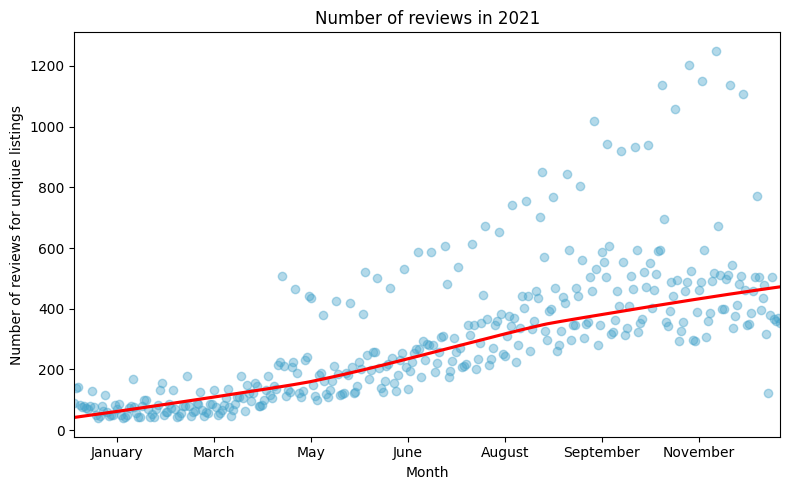

In [381]:
review_plot(num_reviews_2021, fake_month,'listing_id', 'review_2021.png', 'Month', 
            'Number of reviews in 2021', xlim=(18628.0, 18992.0))

<AxesSubplot:title={'center':'Number of reviews in 2022'}, xlabel='Month', ylabel='Number of reviews for unqiue listings'>

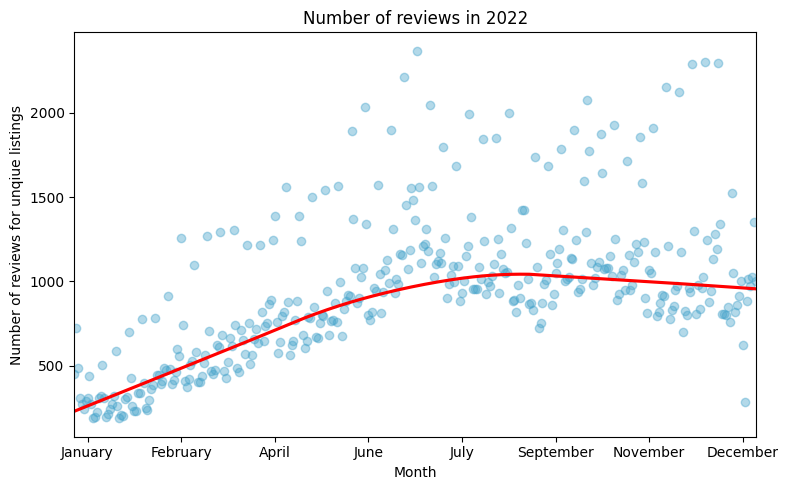

In [380]:
review_plot(num_reviews_2022, fake_month,'listing_id', 'review_2022.png', 'Month', 
            'Number of reviews in 2022', xlim=(18993.0, 19357.0))

<AxesSubplot:title={'center':'Number of reviews in 2023'}, xlabel='Month', ylabel='Number of reviews for unqiue listings'>

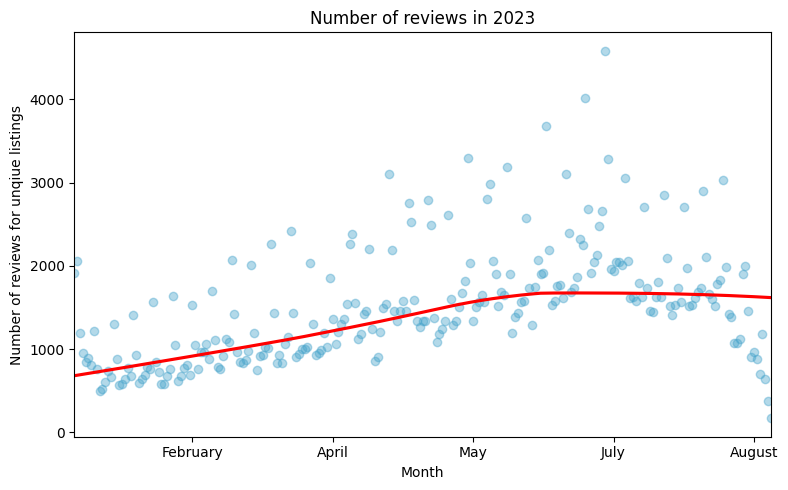

In [379]:
review_plot(num_reviews_2023, fake_month,'listing_id', 'review_2023.png', 'Month', 
            'Number of reviews in 2023', xlim=(19358.0, 19606.0))

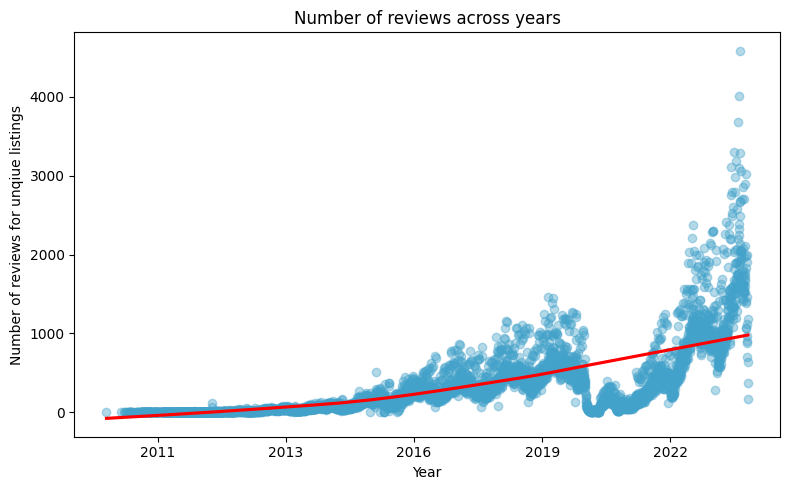

In [317]:
review_plot_full = review_plot(df_reviews, fake_year,'listing_id', 'total_reviews.png', 'Year',
                               'Number of reviews across years')

## We can safely say that Airbnb demand is trending upwards over the years

#  * `9. What is the Impact of external factors such as Economic Indicators to the Price ` 

In [428]:
import pandas_datareader.data as web    # pandas 0.19.x and later
import datetime
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 1, 27) 

#SP500=web.DataReader("SP500", "fred", start, end)

new_df = pd.merge(df_reviews, SP500,  how='inner', left_on=['date'], right_on = ['DATE'])

new_df.head()

from scipy.stats import pearsonr, spearmanr, kendalltau

new_df.fillna(new_df.rolling(window=3, min_periods=1).mean(), inplace=True)


x = new_df['listing_id'].fillna(new_df['listing_id'].mean())
y = new_df['SP500'].fillna(new_df['SP500'].mean())

pearson_coef, _ = pearsonr(x, y)
print("Pearson correlation coefficient:", pearson_coef)

spearman_coef, _ = spearmanr(x, y)
print("Spearman correlation coefficient:", spearman_coef)

kendall_coef, _ = kendalltau(x, y)
print("Kendall correlation coefficient:", kendall_coef)



Pearson correlation coefficient: 0.4786033066569641
Spearman correlation coefficient: 0.5465770145029113
Kendall correlation coefficient: 0.42251296314915593


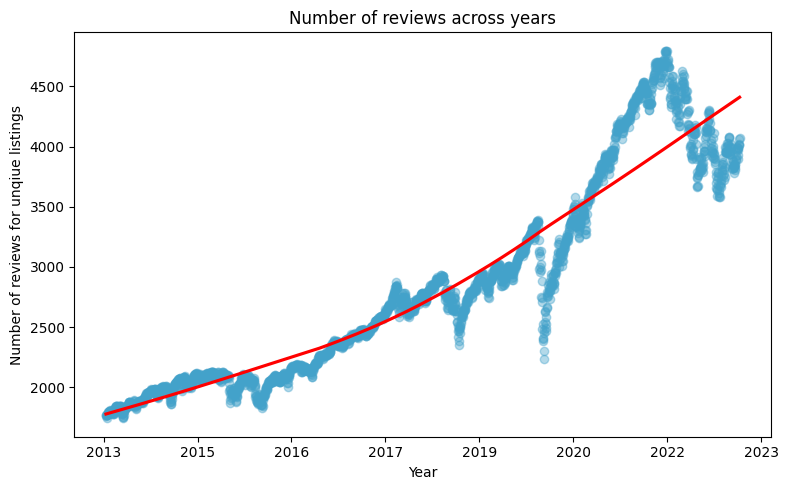

In [370]:
review_plot_full = review_plot(new_df, fake_year,'SP500', 'total_reviews.png', 'Year',
                               'Number of reviews across years')

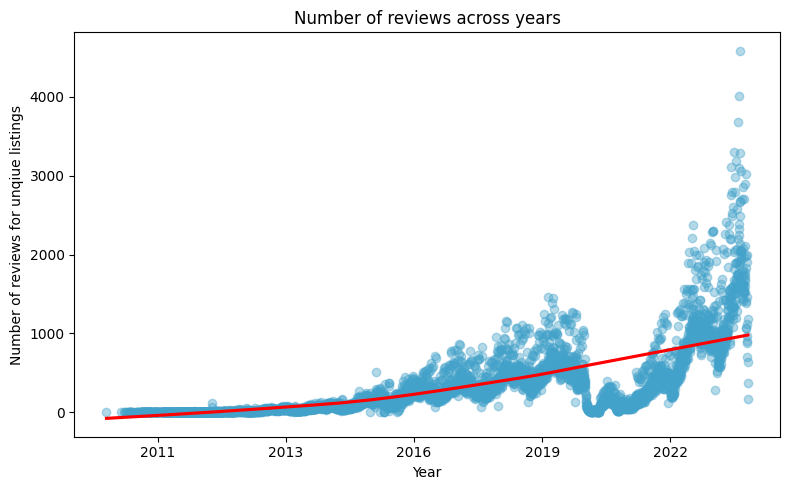

In [372]:
review_plot_full = review_plot(df_reviews, fake_year,'listing_id', 'total_reviews.png', 'Year',
                               'Number of reviews across years')

* The correlation analysis shows that botth Airbnb demand and S&P Global Market has somewhat similar correlation with a Spearman correlation coefficient: 55%, it is also safe to say that the  major pandemics or unexpected event such as Russia vs Ukraine  war, Brexit dealings and Covid pandemic also affected the demands. it will be intteresting to  dig into the inflation data and Uk Global markets. I believe we will see better correlation

# * `10.Use time series analysis (e.g., SARIMA) to detect seasonal trends in prices and occupancy `

In [340]:
# Let's define a EDA function for repeated calls on individual time series:

import statsmodels.api as sm  # seasonal trend decomposition
from statsmodels.graphics import tsaplots   # autocorrelation

def eda(df_name, ts_name, decomp_model='additive'):
    """ 
    Inputs: df_name - name of the dataframe
            ts_name - name of the time series in the dataframe
            decomp_model - 'additive'/'multiplicative'
    Outputs: EDA statistics and plots for individual time series in df_name
    """
    # Statistics
    print(f'Statistic of {ts_name} time series')
    print(df_name[ts_name].describe())
    
    # Plotting
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(24,24))
    fig.suptitle(f'Visualization of the "{ts_name}" time series', fontsize=24)
        
    # Observed values of the time series against target_class values
    df_name[ts_name].plot(ylim=[df_name[ts_name].min(), df_name[ts_name].max()],
                          linewidth=2, ax=axs[0,0])
    axs[0,0].set_title('Observed values (red/green/yellow where target_class=0/1/2)')
    axs[0,0].set_xlabel('')
    axs[0,0].fill_between(df_name.index, df_name[ts_name], 
                          where=(df_name.price==181),
                          facecolor='red', alpha=0.5)

    axs[0,0].axvline('2020-01-01', color='red', linestyle='dashed')

    # Seasonality, trend and noise in time series data
    decomp = sm.tsa.seasonal_decompose(df_name[ts_name],period=12,
                                       model=decomp_model,  extrapolate_trend='freq' )
    decomp.trend.plot(linewidth=2, ax=axs[0,1])
    axs[0,1].set_title('Trend values')
    axs[0,1].set_xlabel('')
    decomp.seasonal.plot(linewidth=2, ax=axs[1,0])
    axs[1,0].set_title('Seasonal values')
    axs[1,0].set_xlabel('')
    decomp.resid.plot(linewidth=2, ax=axs[1,1])
    axs[1,1].set_title('Residual values')
    axs[1,1].set_xlabel('')
    
    # Distribution of values of time series
    df_name[ts_name].plot.hist(bins=30, ax=axs[2,0])
    axs[2, 0].set_title('Histogram')
    df_name[[ts_name]].boxplot(ax=axs[2,1])
    axs[2, 1].set_title('Boxplot')
        
    # Autocorrelation of time series
    tsaplots.plot_acf(df_name[ts_name], lags=40, ax=axs[3,0])
    tsaplots.plot_pacf(df_name[ts_name], lags=40, ax=axs[3,1])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Statistic of price time series
count    87946.000000
mean       181.349817
std        486.174310
min          0.000000
25%         63.000000
50%        110.000000
75%        193.000000
max      80100.000000
Name: price, dtype: float64


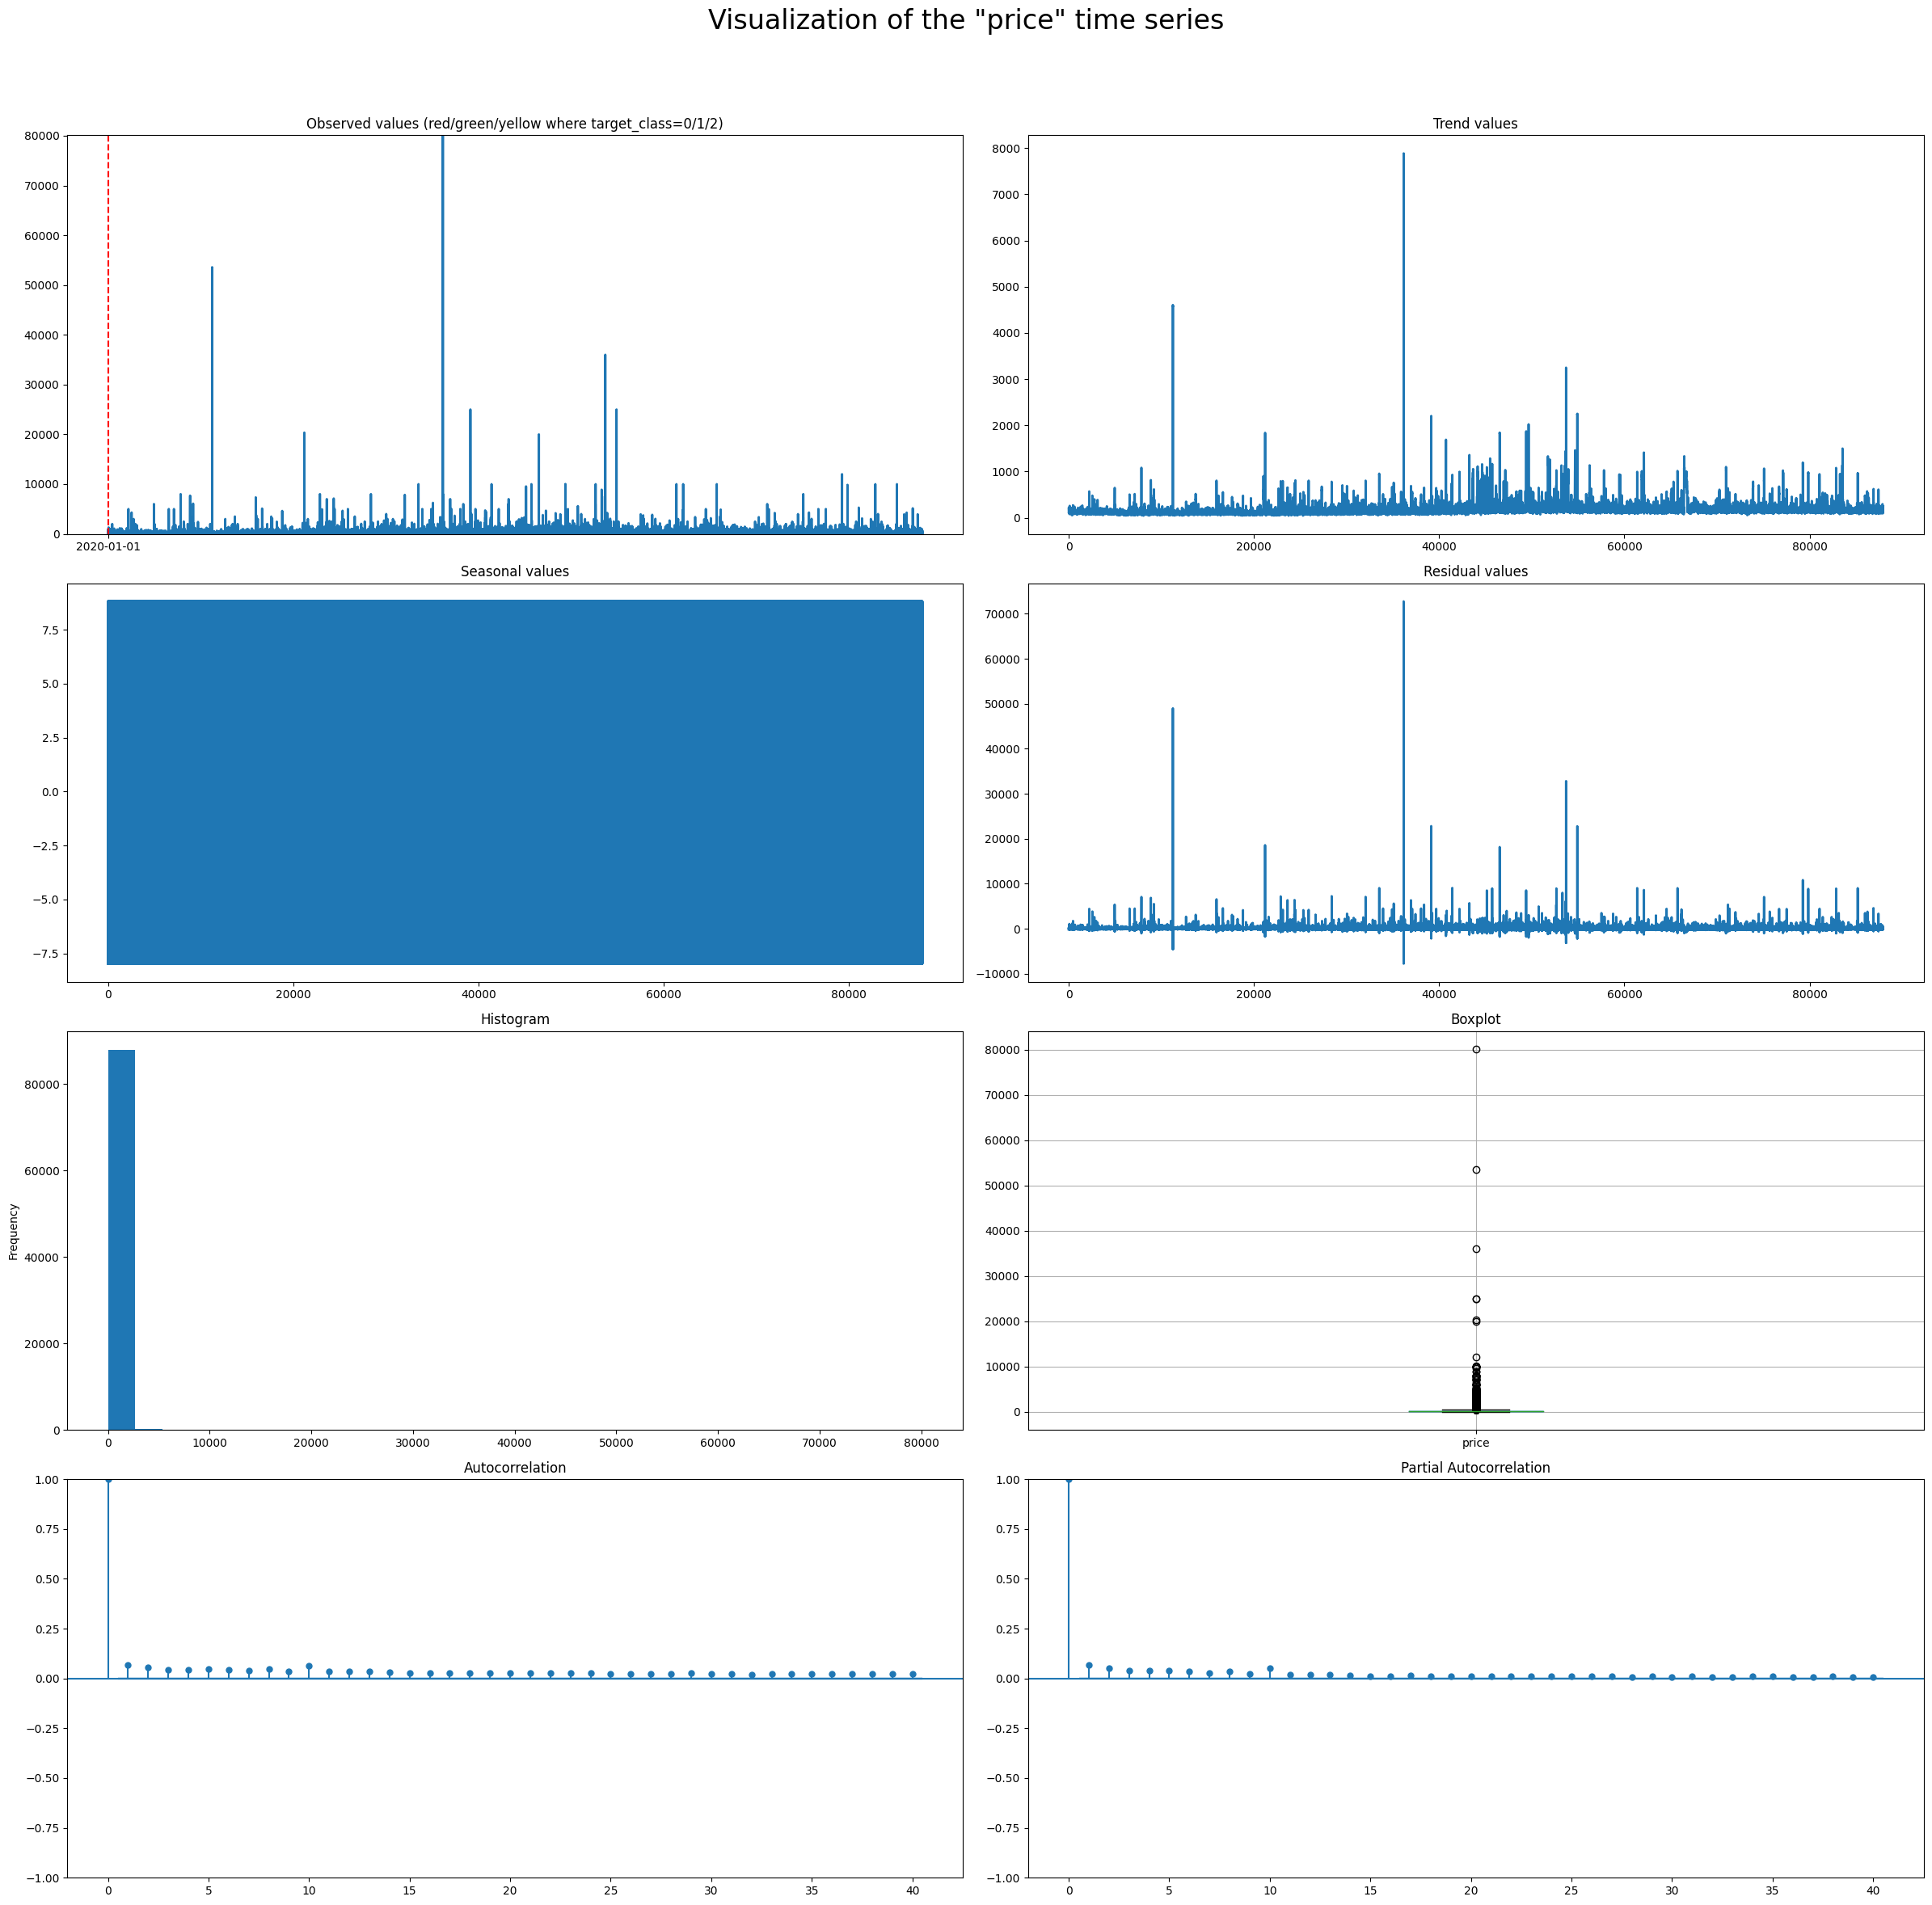

In [341]:
eda(processed_list, 'price', 'additive')

Statistic of booked_365 time series
count    87946.000000
mean        66.818409
std         36.864138
min          0.000000
25%         31.780822
50%         82.191781
75%        100.000000
max        100.000000
Name: booked_365, dtype: float64


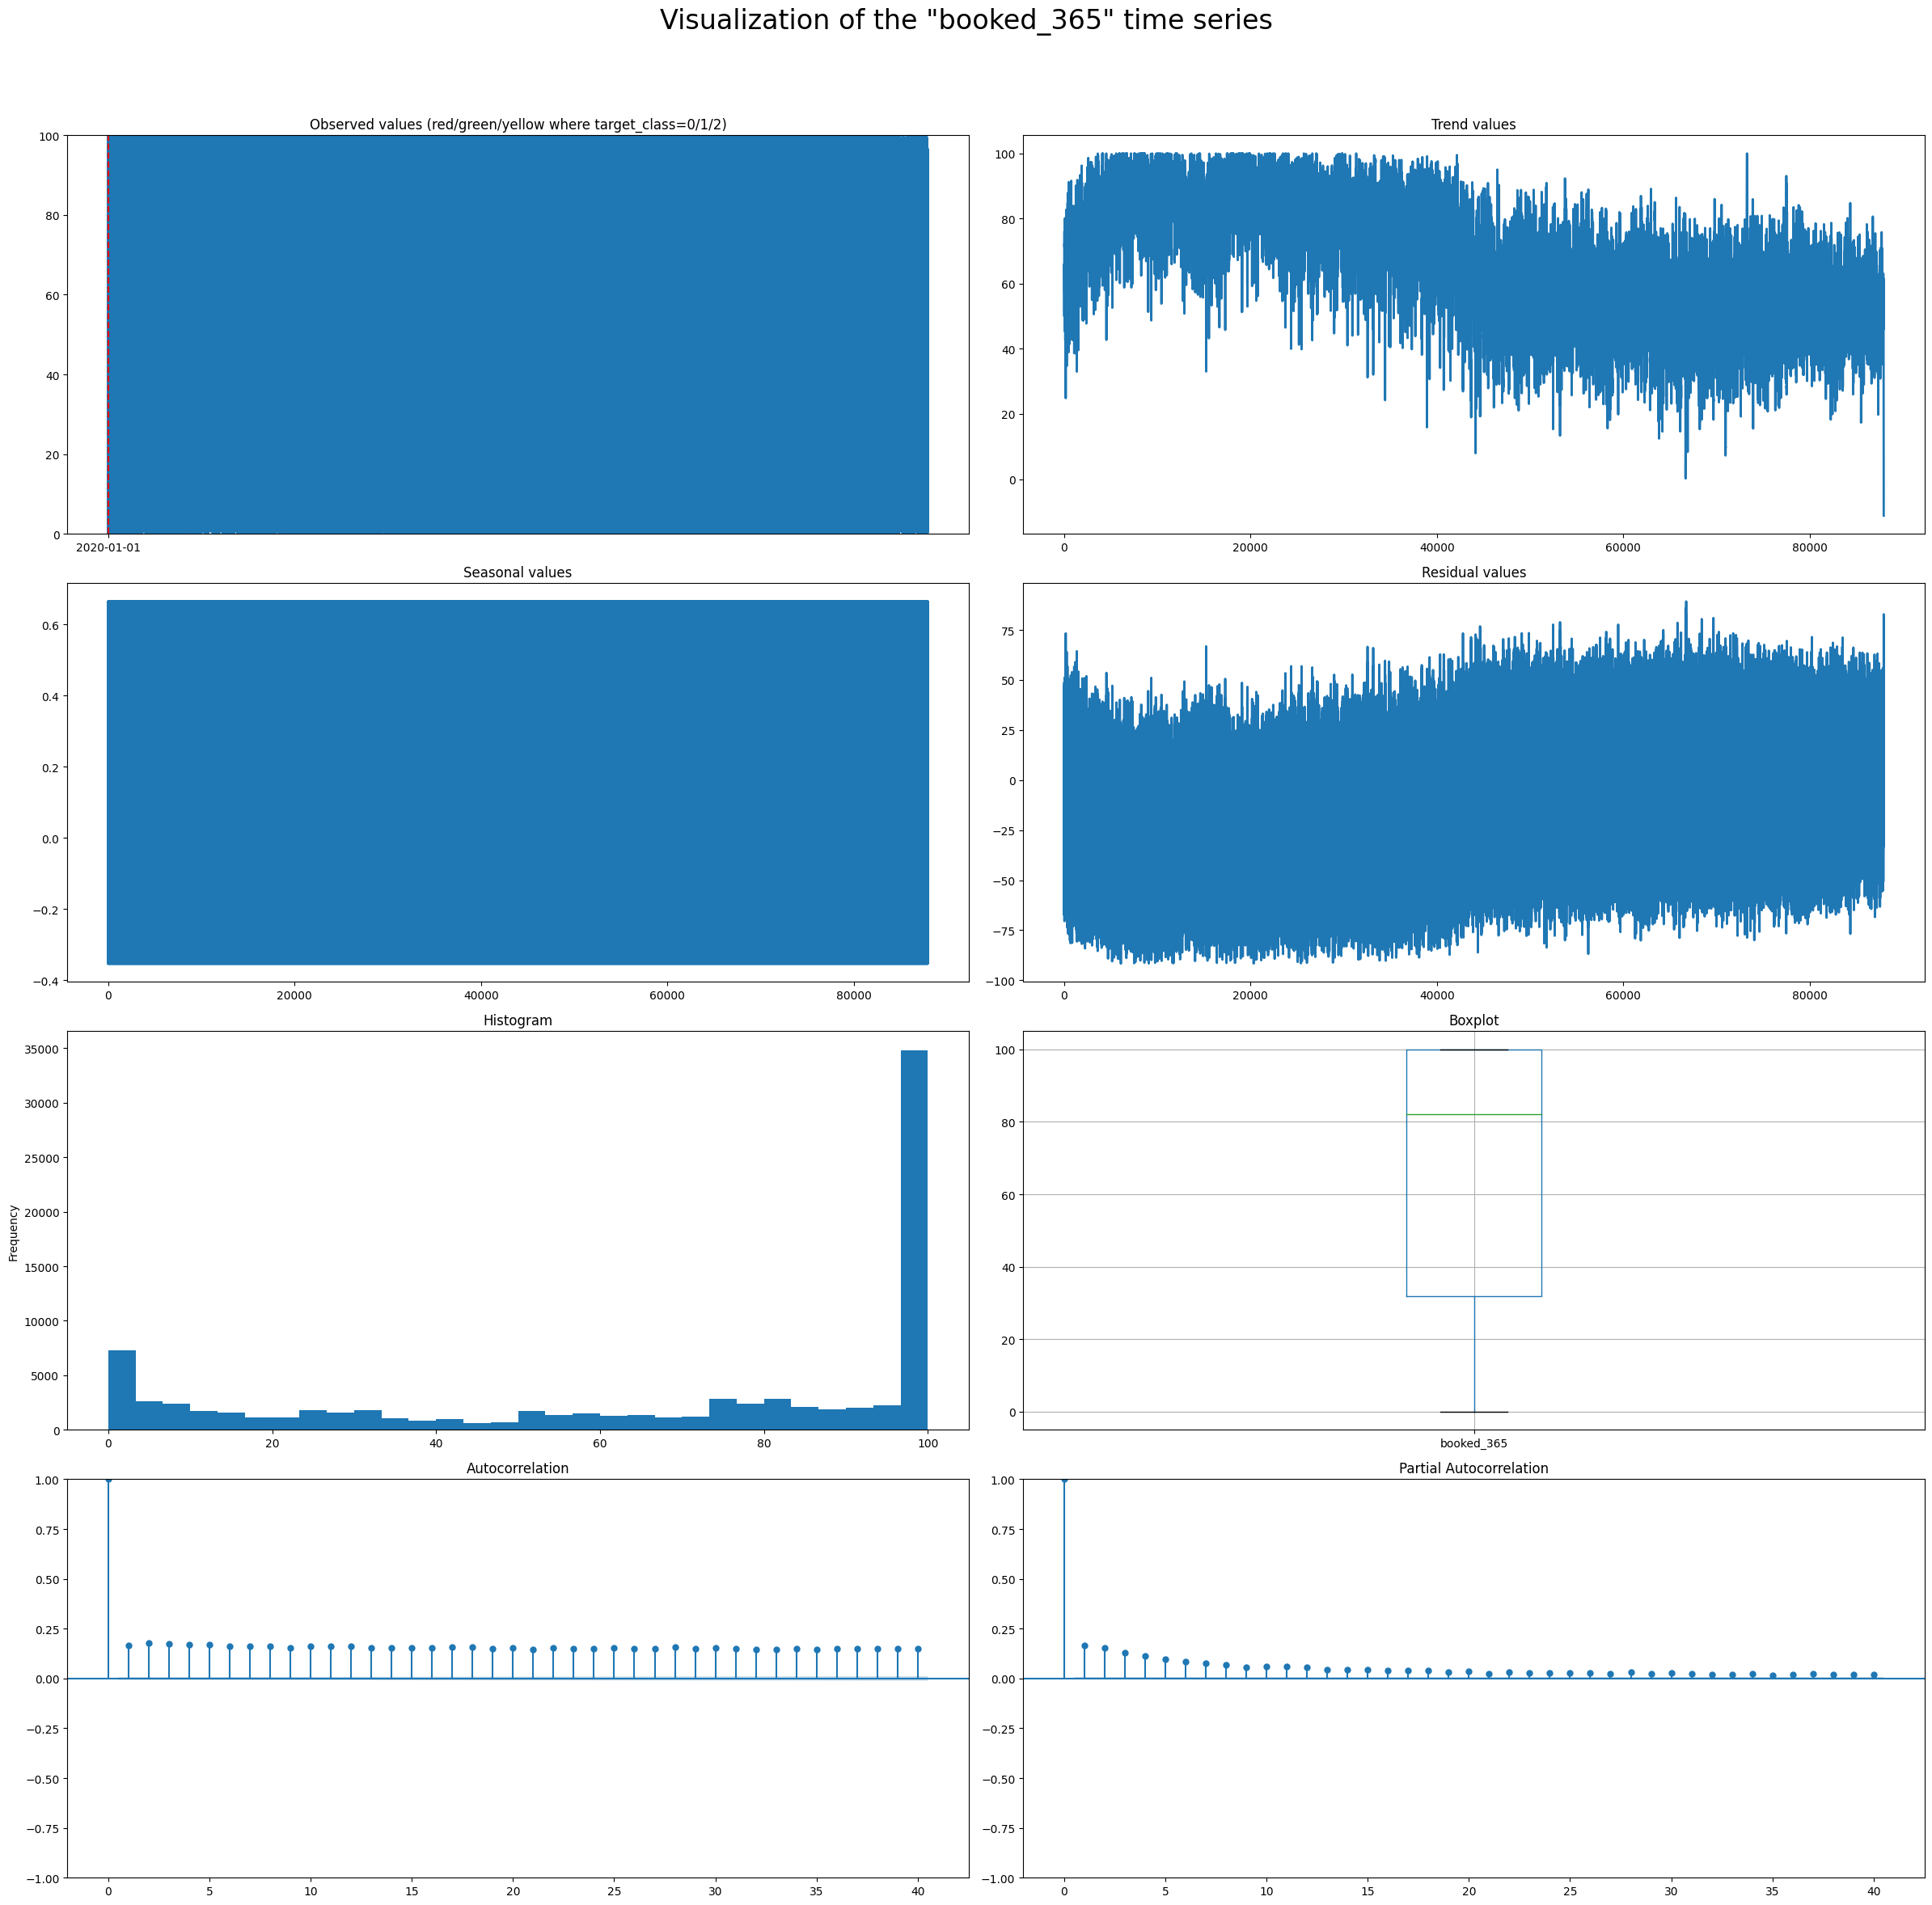

In [342]:
eda(processed_list, "booked_365", 'additive')

* The pattern above shows a strong autocorrelation being skewed to the left, ranging in [0, 3.5], 2nd degree order autocorr